## **P-562- Hourly Energy Consumption Forecast**

**Business Objective**:

PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

●Split the last year into a test set- can you build a model to predict energy consumption?

●Find trends in energy consumption around hours of the day, holidays, or long term trends?

●Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.

●Forecast for next 30 days.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("PJMW_hourly.csv",index_col='Datetime',parse_dates=True)

In [4]:
df.head(10)

PJMW_MW
Datetime                    
2002-12-31 01:00:00   5077.0
2002-12-31 02:00:00   4939.0
2002-12-31 03:00:00   4885.0
2002-12-31 04:00:00   4857.0
2002-12-31 05:00:00   4930.0
2002-12-31 06:00:00   5126.0
2002-12-31 07:00:00   5493.0
2002-12-31 08:00:00   5824.0
2002-12-31 09:00:00   5962.0
2002-12-31 10:00:00   6019.0

In [5]:
df.dtypes

PJMW_MW    float64
dtype: object

In [6]:
#Data Quality Checks
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None

First few rows:
                     PJMW_MW
Datetime                    
2002-12-31 01:00:00   5077.0
2002-12-31 02:00:00   4939.0
2002-12-31 03:00:00   4885.0
2002-12-31 04:00:00   4857.0
2002-12-31 05:00:00   4930.0


In [7]:
df.shape

(143206, 1)

In [8]:
print("Missing Values:\n",df.isnull().sum())

Missing Values:
 PJMW_MW    0
dtype: int64


In [9]:
print("Duplicate Records:",df.duplicated().sum())

Duplicate Records: 137863


In [10]:
#Summary Stats
print("\nSummary Statistics:\n",df.describe().T)


Summary Statistics:
             count         mean         std    min     25%     50%     75%  \
PJMW_MW  143206.0  5602.375089  979.142872  487.0  4907.0  5530.0  6252.0   

            max  
PJMW_MW  9594.0  


In [11]:
df['PJMW_MW'].skew()

0.3348532861122116

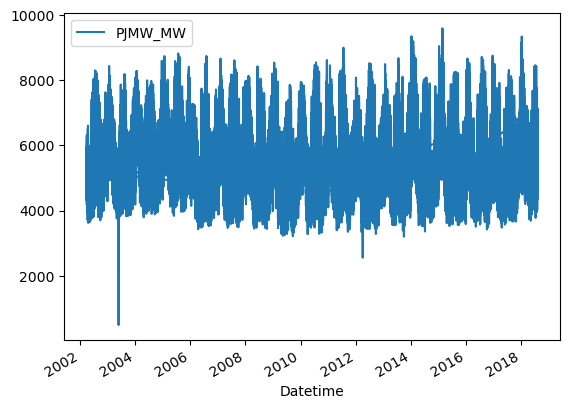

In [12]:
df.plot()
pyplot.show()

array([[<Axes: title={'center': 'PJMW_MW'}>]], dtype=object)

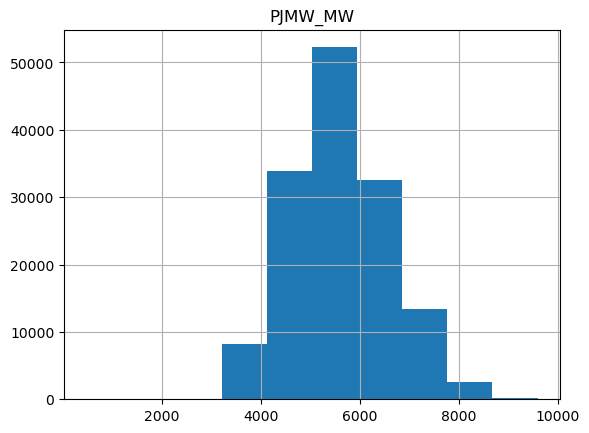

In [13]:
df.hist()

<Axes: ylabel='Density'>

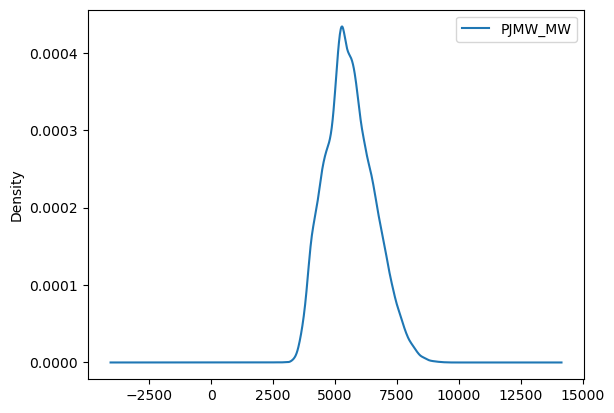

In [14]:
df.plot(kind="kde")

In [15]:
pip install holidays

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 29.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
data = df.copy()

# Extract features for analysis from index (DatetimeIndex)
data['hour'] = data.index.hour
data['Day'] = data.index.day
data['Month'] = data.index.month
data['Year'] = data.index.year
data['weekday'] = data.index.weekday


In [17]:
data

PJMW_MW  hour  Day  Month  Year  weekday
Datetime                                                     
2002-12-31 01:00:00   5077.0     1   31     12  2002        1
2002-12-31 02:00:00   4939.0     2   31     12  2002        1
2002-12-31 03:00:00   4885.0     3   31     12  2002        1
2002-12-31 04:00:00   4857.0     4   31     12  2002        1
2002-12-31 05:00:00   4930.0     5   31     12  2002        1
...                      ...   ...  ...    ...   ...      ...
2018-01-01 20:00:00   8401.0    20    1      1  2018        0
2018-01-01 21:00:00   8373.0    21    1      1  2018        0
2018-01-01 22:00:00   8238.0    22    1      1  2018        0
2018-01-01 23:00:00   7958.0    23    1      1  2018        0
2018-01-02 00:00:00   7691.0     0    2      1  2018        1

[143206 rows x 6 columns]

In [18]:
import holidays

# Ensure datetime index
data.index = pd.to_datetime(data.index)

#  Add time-based features
data['hour'] = data.index.hour         # Hour of the day (0-23)
data['dayofweek'] = data.index.dayofweek  # Day of the week (0=Mon, 6=Sun)

# Add US Holiday indicator
us_holidays = holidays.US()
data['is_holiday'] = data.index.to_series().apply(lambda x: x.date() in us_holidays)

# Group and compute average consumption per hour for holidays vs non-holidays
holiday_hourly_avg = data[data['is_holiday']].groupby('hour')['PJMW_MW'].mean()
non_holiday_hourly_avg = data[~data['is_holiday']].groupby('hour')['PJMW_MW'].mean()


Holiday rows: 4320
Non-holiday rows: 138886


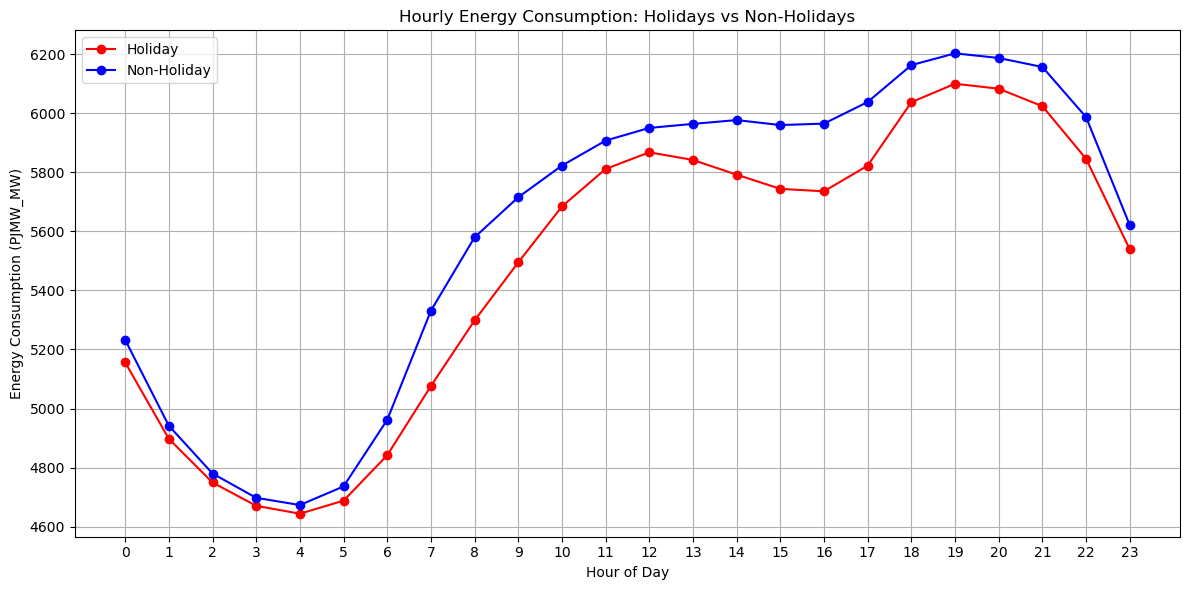

In [19]:

# Make sure index is datetime
data.index = pd.to_datetime(data.index)

# Extract 'hour'
data['hour'] = data.index.hour

# Add US holiday info
us_holidays = holidays.US()
data['is_holiday'] = data.index.to_series().apply(lambda x: x.date() in us_holidays)

# Check for valid rows
print("Holiday rows:", data['is_holiday'].sum())
print("Non-holiday rows:", (~data['is_holiday']).sum())

# Group by hour and calculate mean consumption
holiday_avg = data[data['is_holiday']].groupby('hour')['PJMW_MW'].mean()
non_holiday_avg = data[~data['is_holiday']].groupby('hour')['PJMW_MW'].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(holiday_avg.index, holiday_avg.values, label='Holiday', color='red', marker='o')
plt.plot(non_holiday_avg.index, non_holiday_avg.values, label='Non-Holiday', color='blue', marker='o')
plt.title('Hourly Energy Consumption: Holidays vs Non-Holidays')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (PJMW_MW)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

On non-holidays, energy consumption is consistently higher, especially during working hours (7 AM–5 PM), due to industrial and commercial activity. Holidays show lower and smoother demand, with peaks mainly in the evening. This highlights the influence of workday routines on electricity usage.

**Resampling**

In [22]:
# Resample by Hour
hourly_avg=data.resample('H').mean()


# Resample by day
daily_avg=data.resample('D').mean()

# Resample by week
weekly_avg=data.resample('W').mean()

# Resample by month
monthly_avg=data.resample('M').mean()

In [23]:
hourly_avg.interpolate(method='linear')
daily_avg.interpolate(method='linear')
weekly_avg.interpolate(method='linear')
monthly_avg.interpolate(method='linear')

PJMW_MW       hour        Day  Month    Year   weekday  \
Datetime                                                                 
2002-04-30  5171.318942  11.527855  15.532033    4.0  2002.0  2.832869   
2002-05-31  5085.094086  11.500000  16.000000    5.0  2002.0  3.000000   
2002-06-30  5685.681944  11.500000  15.500000    6.0  2002.0  3.166667   
2002-07-31  6097.877688  11.500000  16.000000    7.0  2002.0  2.806452   
2002-08-31  6063.909946  11.500000  16.000000    8.0  2002.0  3.096774   
...                 ...        ...        ...    ...     ...       ...   
2018-04-30  5281.277778  11.500000  15.500000    4.0  2018.0  3.000000   
2018-05-31  5278.620968  11.500000  16.000000    5.0  2018.0  2.903226   
2018-06-30  5559.326389  11.500000  15.500000    6.0  2018.0  3.100000   
2018-07-31  5978.728495  11.500000  16.000000    7.0  2018.0  2.935484   
2018-08-31  5874.346939  11.265306   1.530612    8.0  2018.0  2.530612   

            dayofweek  is_holiday  
Datetime                           
2002-04-30   2.832869    0.000000  
2002-05-31   3.000000    0.032258  
2002-06-30   3.166667    0.000000  
2002-07-31   2.806452    0.032258  
2002-08-31   3.096774    0.000000  
...               ...         ...  
2018-04-30   3.000000    0.000000  
2018-05-31   2.903226    0.032258  
2018-06-30   3.100000    0.000000  
2018-07-31   2.935484    0.032258  
2018-08-31   2.530612    0.000000  

[197 rows x 8 columns]

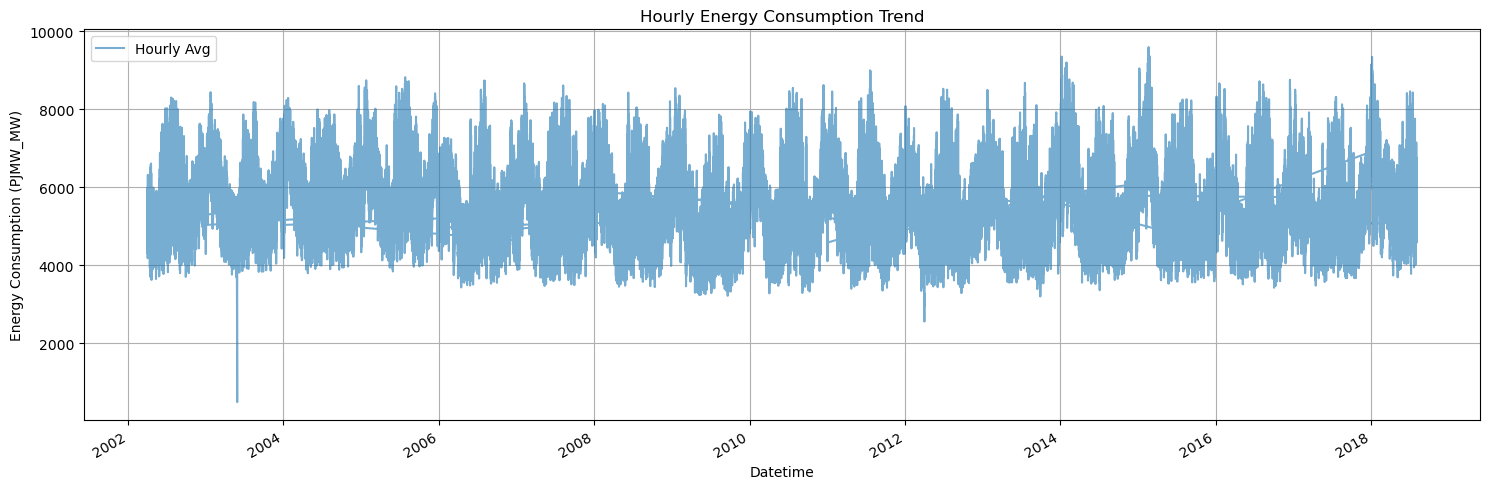

In [24]:
plt.figure(figsize=(15, 5))
data['PJMW_MW'].plot(label='Hourly Avg', alpha=0.6)
plt.title('Hourly Energy Consumption Trend')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (PJMW_MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


There's a strong seasonal pattern, with regular peaks and troughs repeating annually.

Energy demand is higher during certain months (likely winter/summer due to heating/cooling needs).

Despite fluctuations, the overall range remains stable between ~4000 MW and ~8500 MW.

Occasional sharp drops or spikes may indicate anomalies or outages

<Figure size 1600x1000 with 0 Axes>

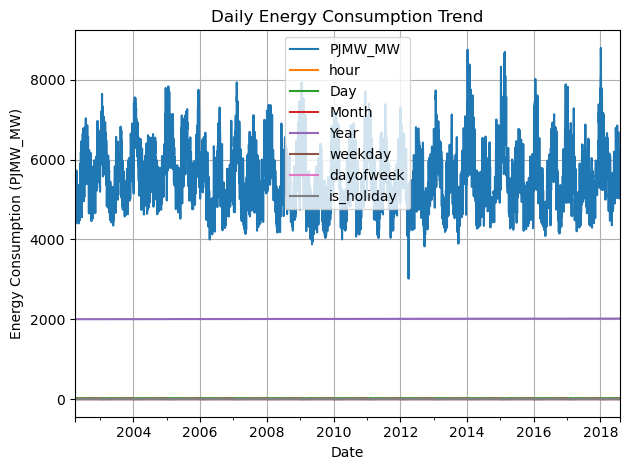

In [26]:
#Daily Energy Consumption Trend
plt.figure(figsize=(16, 10))
daily_avg.plot(label='Daily Avg')
plt.title('Daily Energy Consumption Trend')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (PJMW_MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
#Extracting season column from index to visualize Seasonal trends
#defining a function to sort seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

#Extract season and year
data['Season'] = data['Month'].apply(get_season)

#Group by Season and Year
seasonal_summary = data.groupby(['Year', 'Season'])['PJMW_MW'].sum().reset_index()

#Pivot for plotting
seasonal_pivot = seasonal_summary.pivot(index='Year', columns='Season', values='PJMW_MW')

In [28]:
# Map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Season'] = data['Month'].apply(get_season)

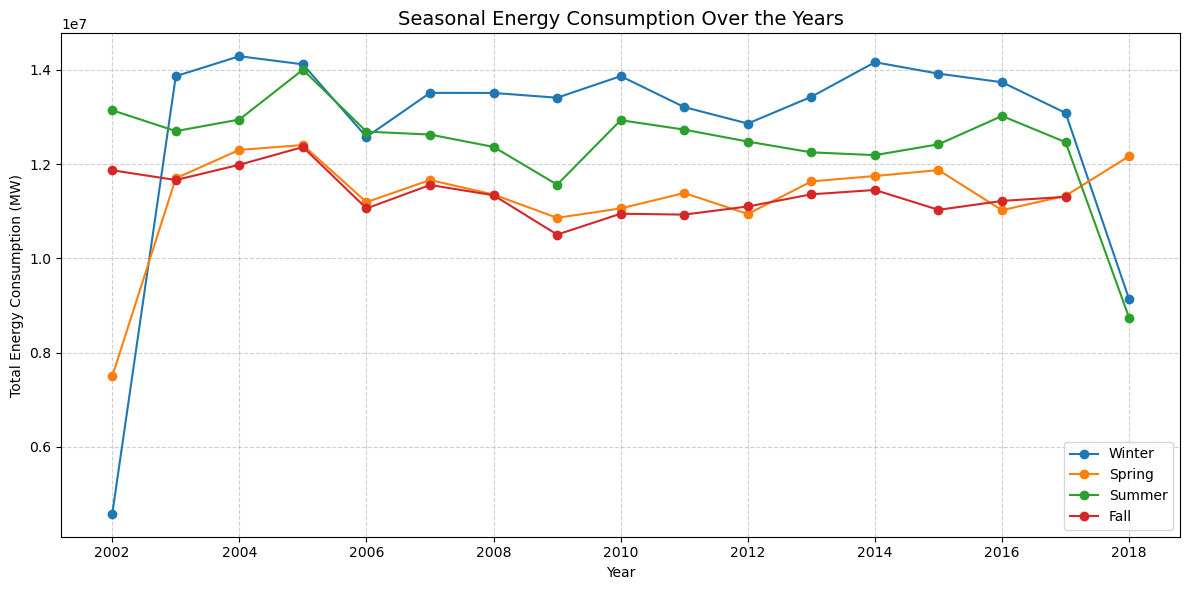

In [29]:
plt.figure(figsize=(12, 6))
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in seasonal_pivot.columns:
        plt.plot(seasonal_pivot.index, seasonal_pivot[season], label=season, marker='o')

plt.title('Seasonal Energy Consumption Over the Years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


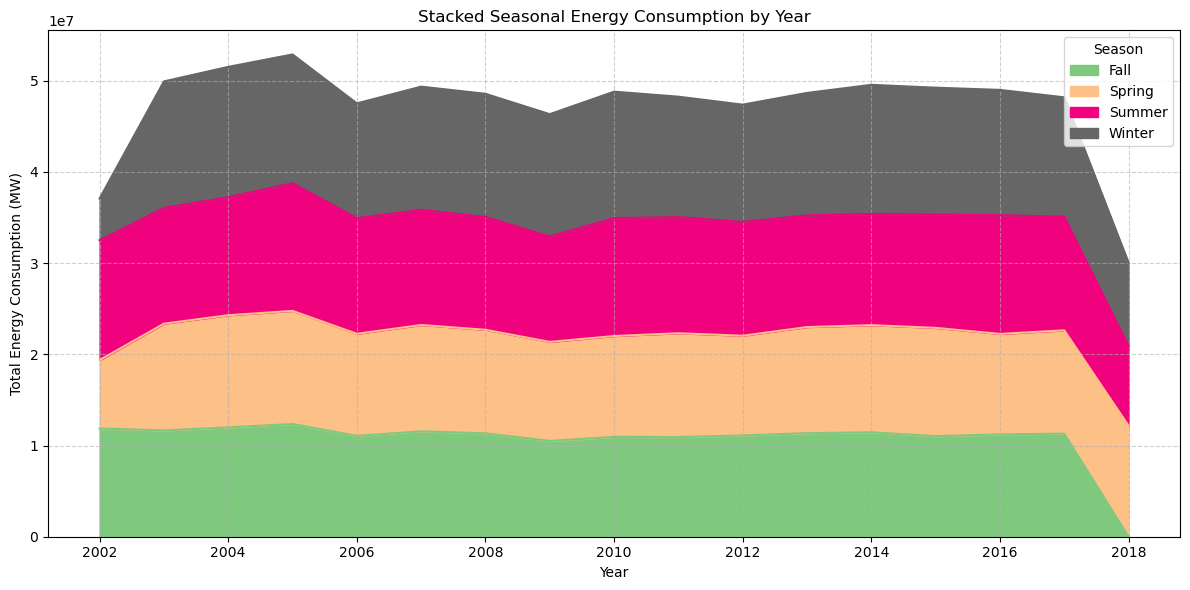

In [30]:
seasonal_pivot.fillna(0, inplace=True)  # Ensure no NaNs

seasonal_pivot.plot(kind='area', figsize=(12, 6), stacked=True, colormap='Accent')
plt.title('Stacked Seasonal Energy Consumption by Year')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (MW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


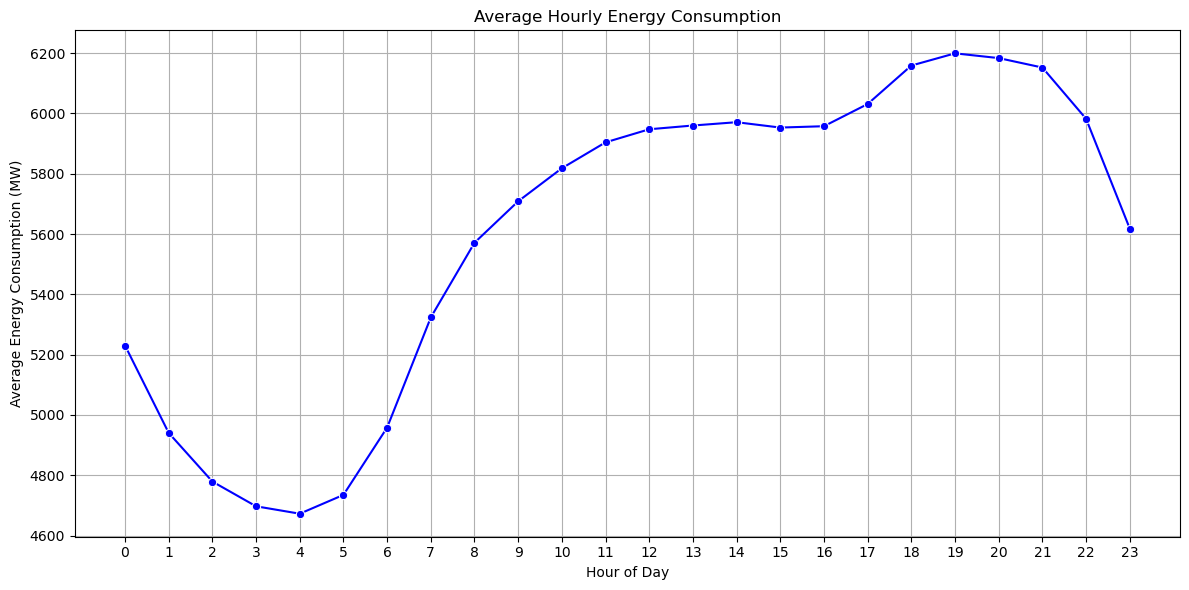

In [31]:
# Group by hour and calculate mean
hourly_avg = data.groupby(data.index.hour)['PJMW_MW'].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='blue')
plt.title('Average Hourly Energy Consumption')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (MW)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


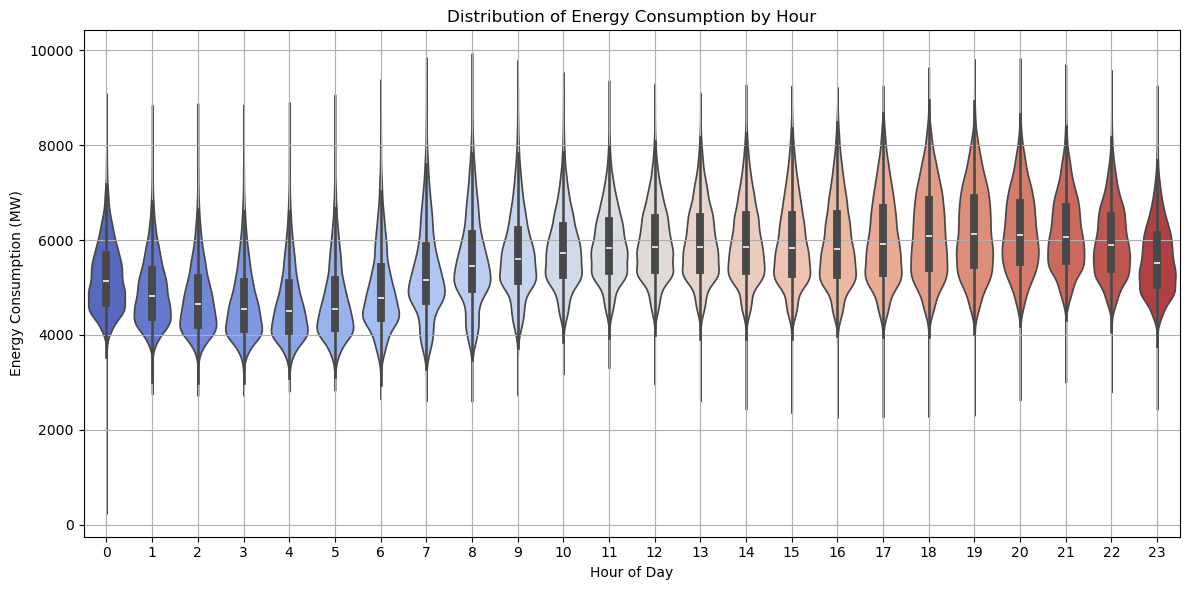

In [32]:
# Create 'Hour' column if not already created
data['Hour'] = data.index.hour

plt.figure(figsize=(12, 6))
sns.violinplot(x='Hour', y='PJMW_MW', data=data, palette='coolwarm')
plt.title('Distribution of Energy Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


The violin plot highlights clear **diurnal seasonality** in energy consumption. Demand is **lowest during early morning hours (2–6 AM)** and gradually increases, peaking between 17:00 and 20:00 hours. The wider distribution during peak hours suggests higher variability, indicating inconsistent usage during evenings. This pattern validates the presence of **hourly cyclical trends** and supports time series decomposition or seasonal modeling approaches.

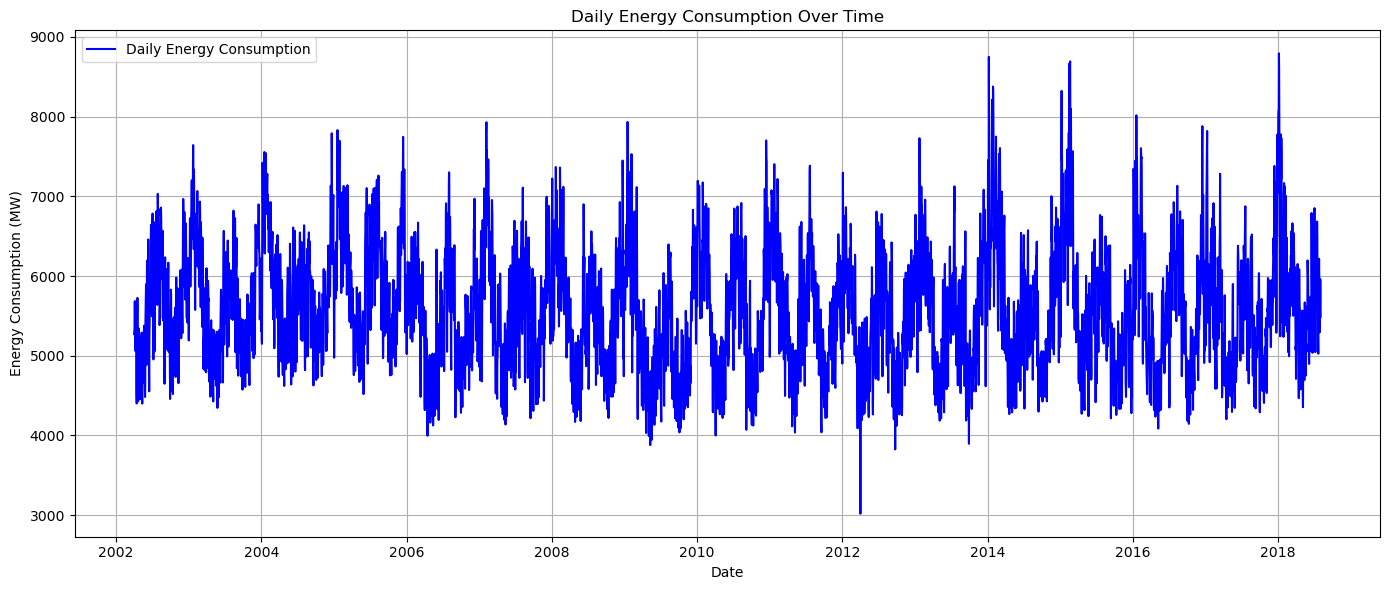

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(daily_avg['PJMW_MW'], label='Daily Energy Consumption', color='blue')
plt.title('Daily Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The line plot reveals clear yearly seasonality in daily energy consumption, with repetitive peaks and troughs across years. High consumption typically aligns with summer and winter months, indicating temperature-driven demand. The series also shows non-stationarity with varying amplitude over time, suggesting a need for differencing or transformation before modeling

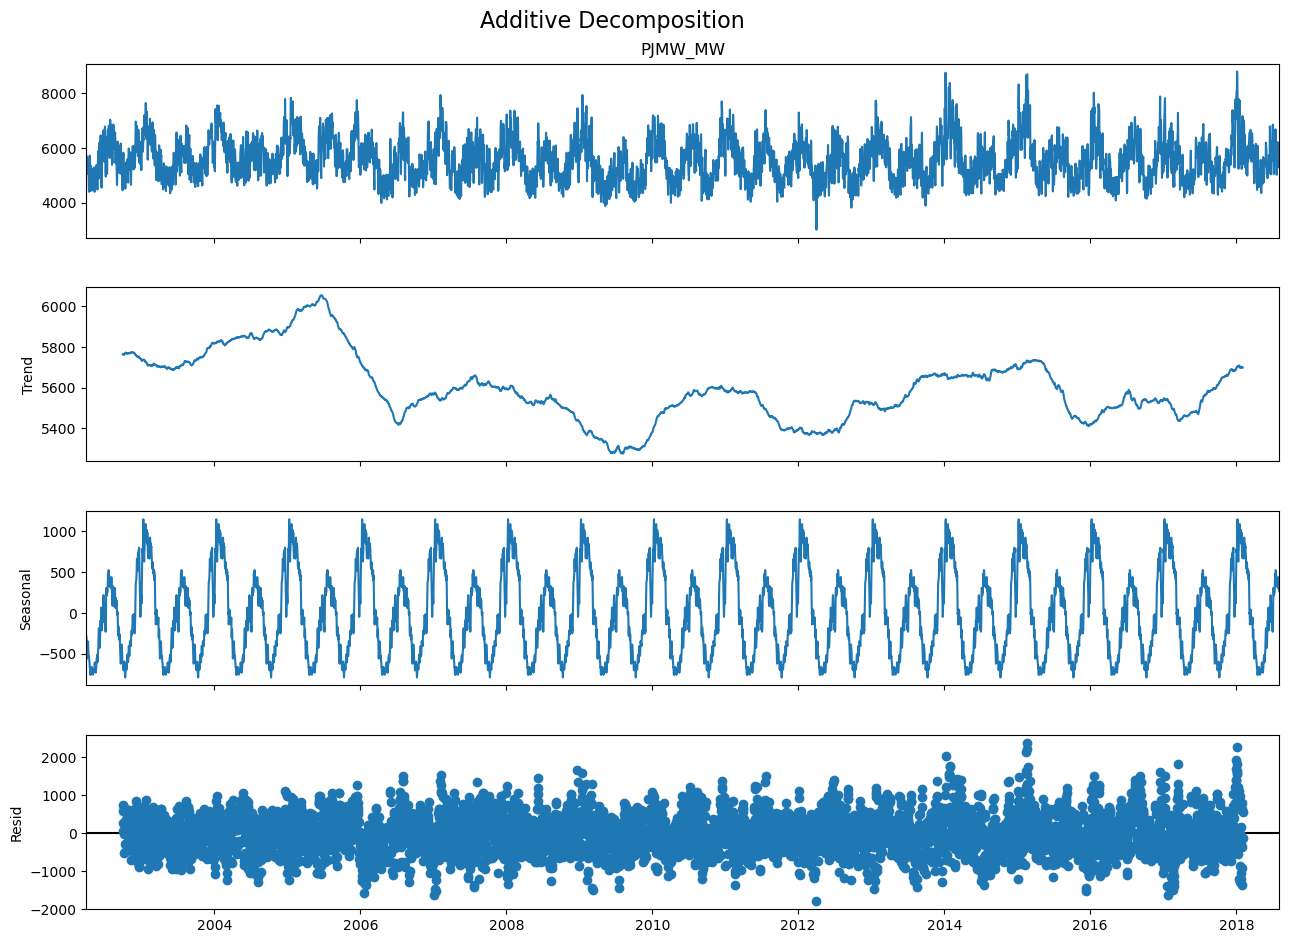

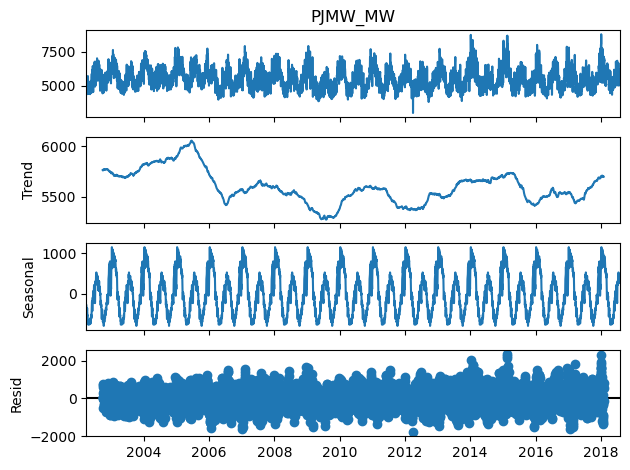

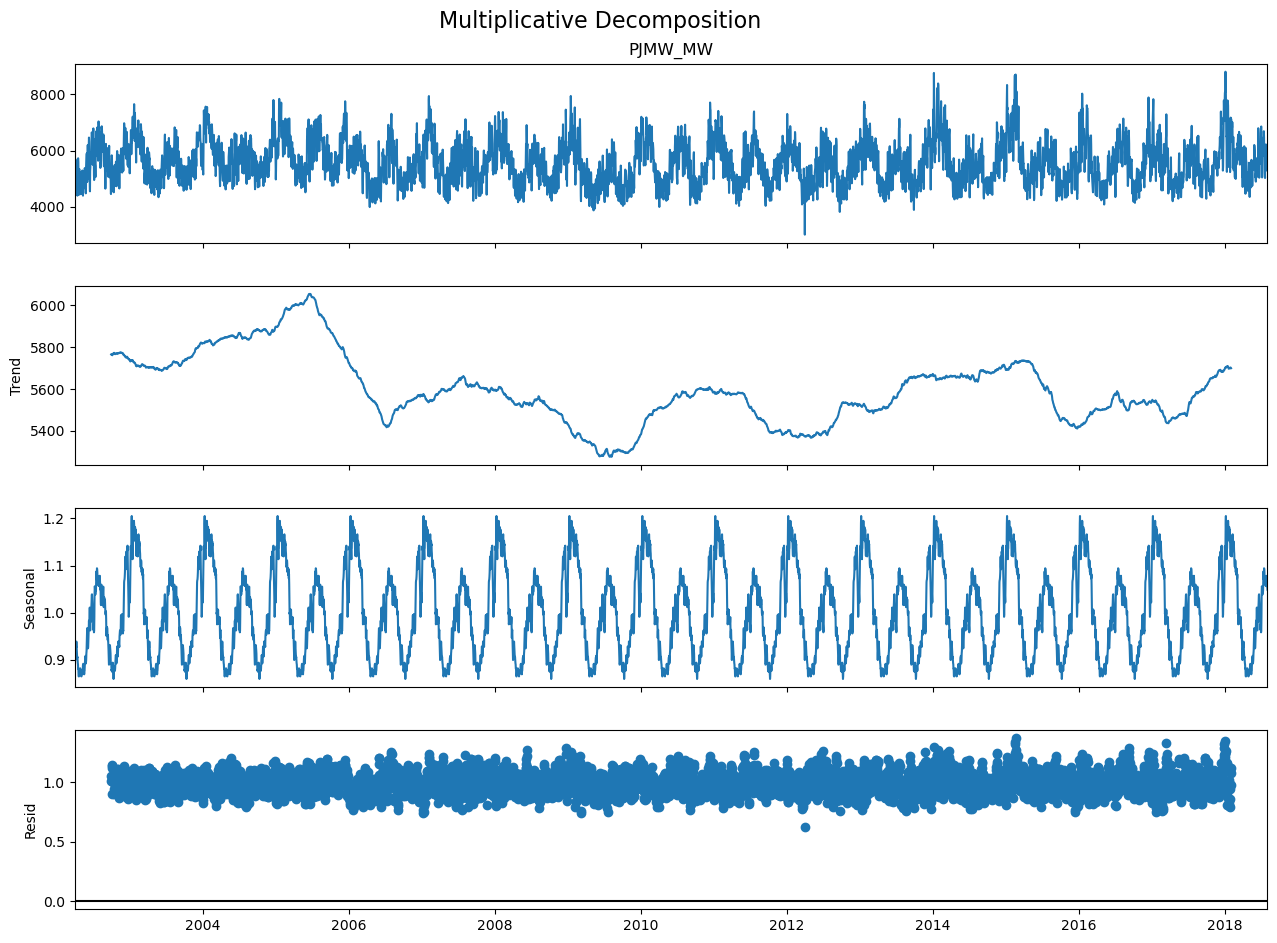

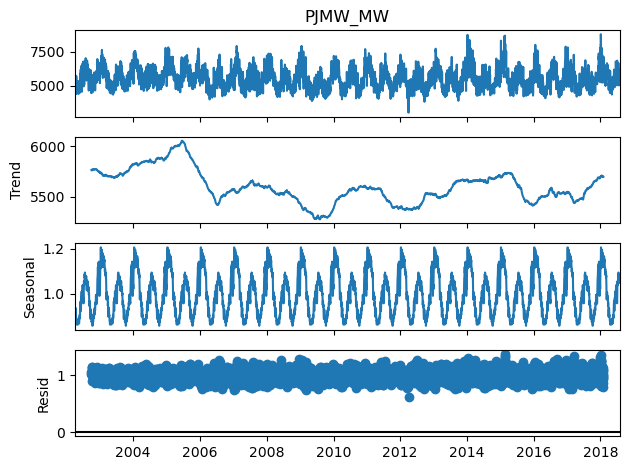

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure data is datetime indexed and has no NaNs
daily_avg = daily_avg.dropna()

# Additive model decomposition
result_add = seasonal_decompose(daily_avg['PJMW_MW'], model='additive', period=365)

# Multiplicative model decomposition
result_mul = seasonal_decompose(daily_avg['PJMW_MW'], model='multiplicative', period=365)

# Plot additive decomposition
fig_add = result_add.plot()
fig_add.set_size_inches(14, 10)
plt.suptitle('Additive Decomposition', fontsize=16)
result_add.plot()
plt.tight_layout()
plt.show()

# Plot multiplicative decomposition
fig_mul = result_mul.plot()
fig_mul.set_size_inches(14, 10)
plt.suptitle('Multiplicative Decomposition', fontsize=16)
result_mul.plot()
plt.tight_layout()
plt.show()


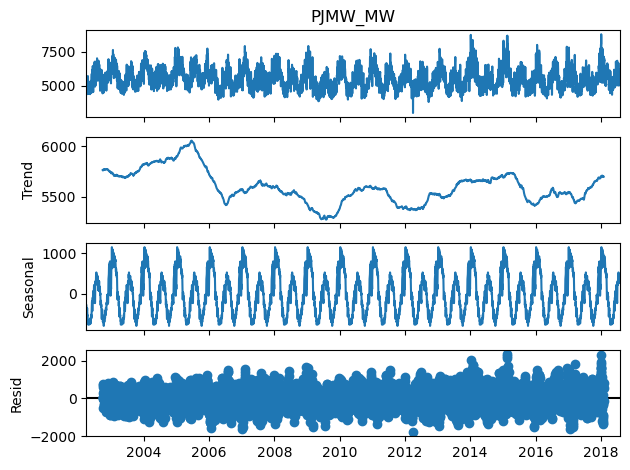

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure index is datetime
daily_avg = daily_avg.dropna()  # Remove NaNs if any
result = seasonal_decompose(daily_avg['PJMW_MW'], model='additive', period=365)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()


A long-term fluctuating trend in energy consumption over the years.

A strong and regular seasonal component, showing annual cycles.

Residuals appear randomly distributed, indicating that the additive model captures most of the structure.

Both trend and seasonality are present in the energy consumption data.

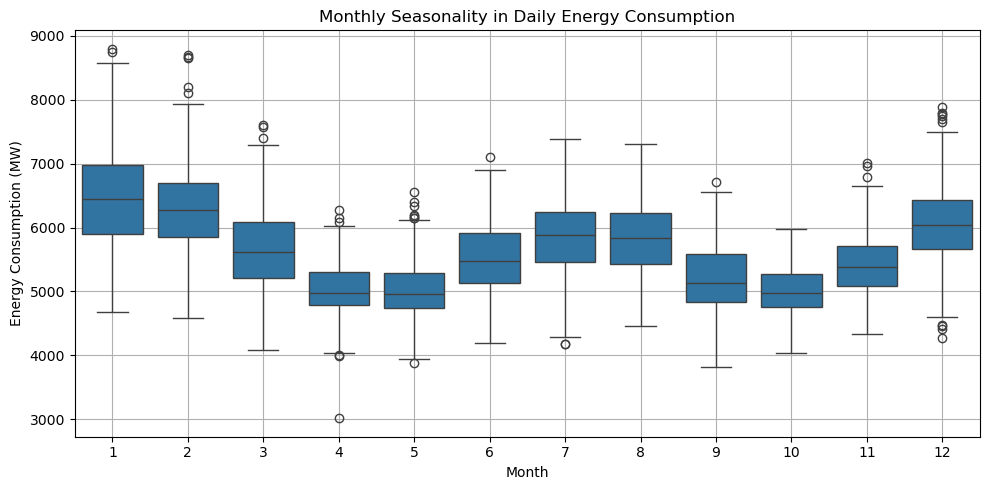

In [39]:
daily_avg['Month'] = daily_avg.index.month

import seaborn as sns
plt.figure(figsize=(10, 5))
sns.boxplot(x='Month', y='PJMW_MW', data=daily_avg)
plt.title('Monthly Seasonality in Daily Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


**Transformations**

In [41]:
daily_avg['Log_PJMW_MW'] = np.log(daily_avg['PJMW_MW'])


In [42]:
daily_avg['Diff_Log'] = daily_avg['Log_PJMW_MW'].diff()


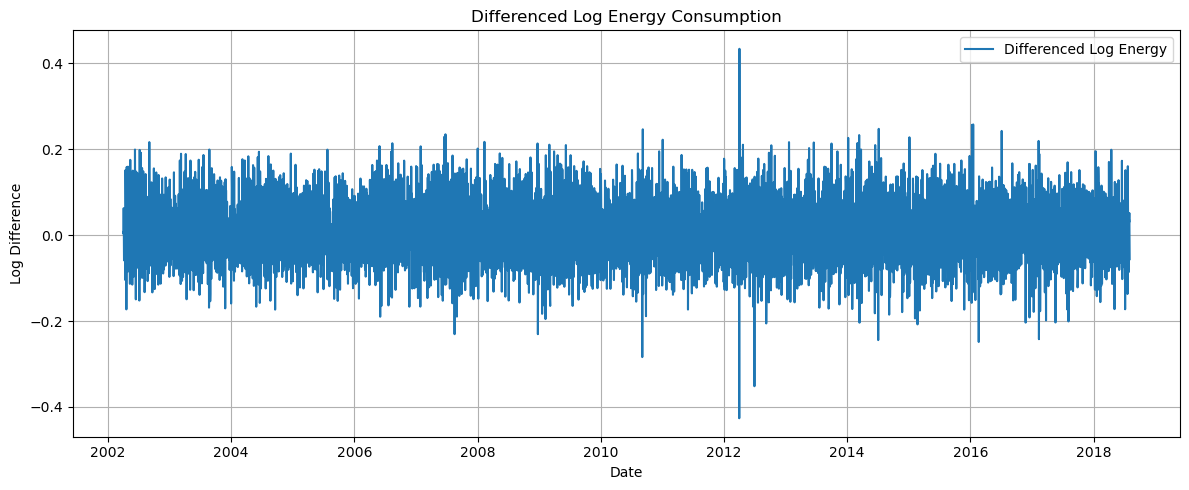

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(daily_avg['Diff_Log'], label='Differenced Log Energy')
plt.title('Differenced Log Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Log Difference')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


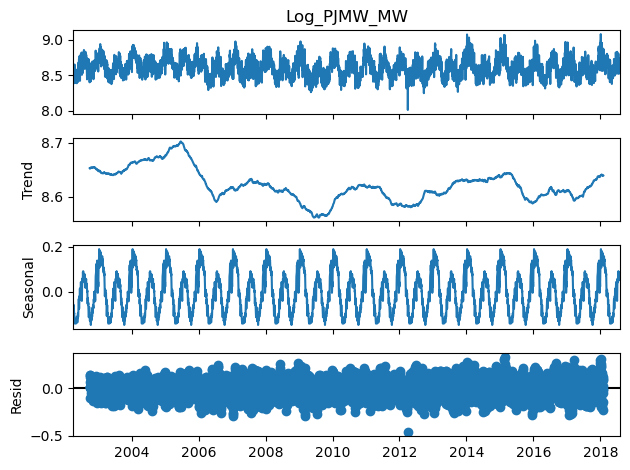

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_avg['Log_PJMW_MW'].dropna(), model='additive', period=365)
decomposition.plot()
plt.tight_layout()
plt.show()


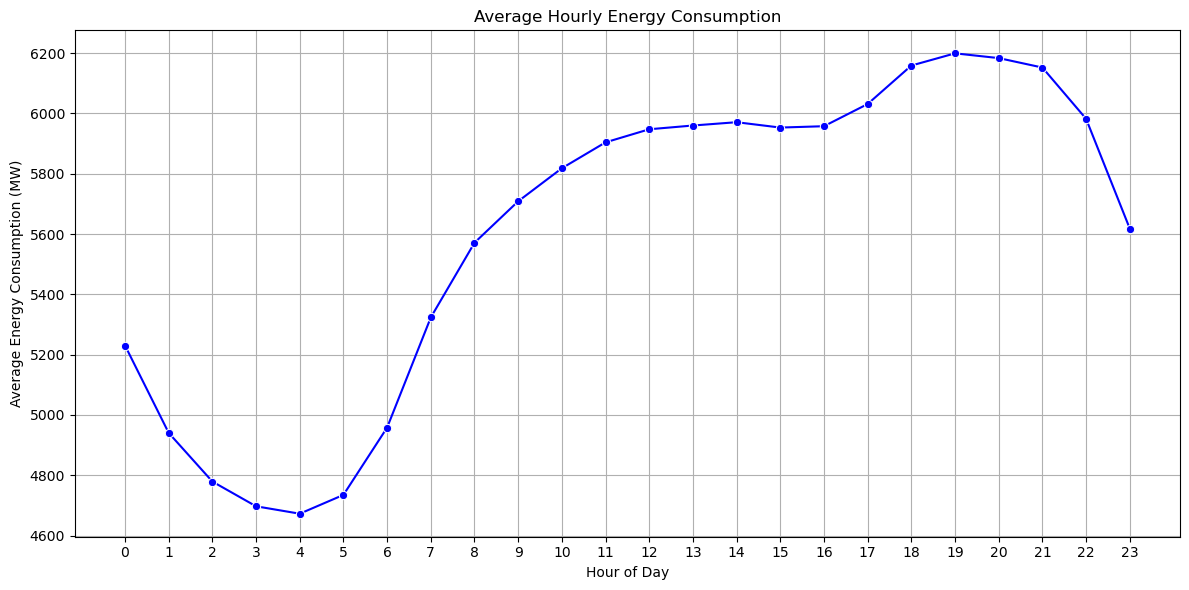

In [45]:
# Group by hour and calculate mean
hourly_avg = data.groupby(data.index.hour)['PJMW_MW'].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='blue')
plt.title('Average Hourly Energy Consumption')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (MW)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

**Heatmap**

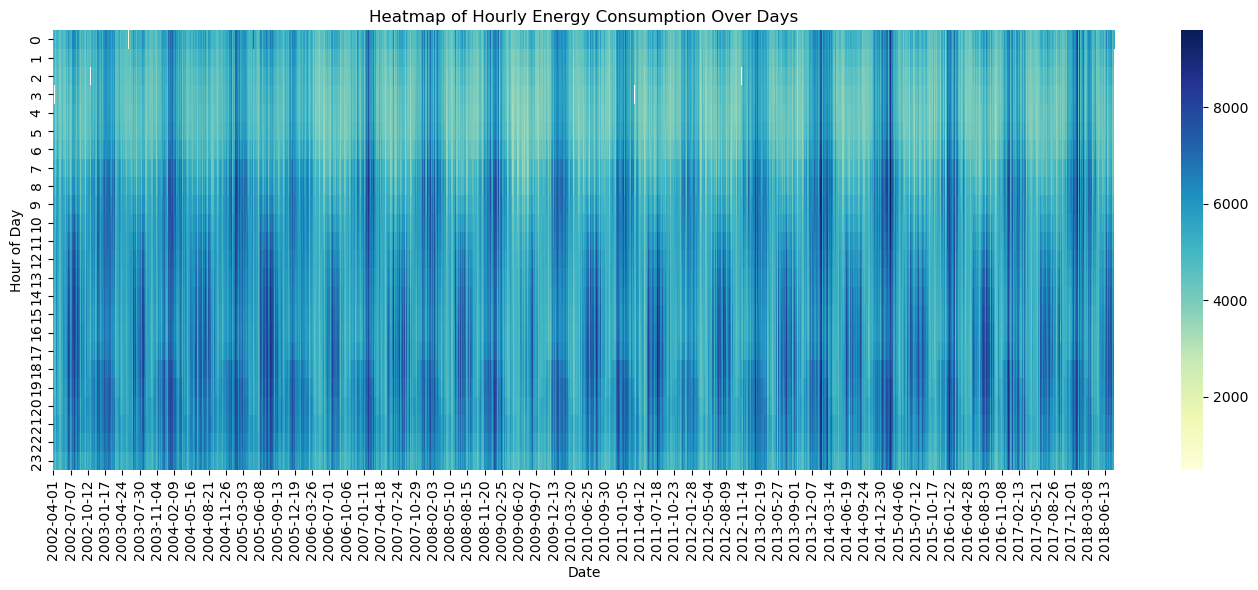

In [47]:
# Extract hour and date
data['Day'] = data.index.date
pivot_table = data.pivot_table(index=data.index.hour, columns='Day', values='PJMW_MW')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Heatmap of Hourly Energy Consumption Over Days')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()


The heatmap reveals strong intraday seasonality, with peak energy consumption occurring during late afternoon to evening hours (16–20 hrs) and minimum usage during early morning hours (0–5 hrs). Repeating daily patterns across the timeline indicate cyclical demand behavior, while subtle long-term variations suggest underlying trend components and possible yearly seasonality

**Stationarity Check**

In [50]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_avg['Diff_Log'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -14.111538160655618
p-value: 2.5147844944671914e-26


The ADF test result shows a very low p-value (≈ 0) and a strongly negative ADF statistic, indicating the null hypothesis of non-stationarity is rejected.


 The transformed series is stationary and ready for forecasting

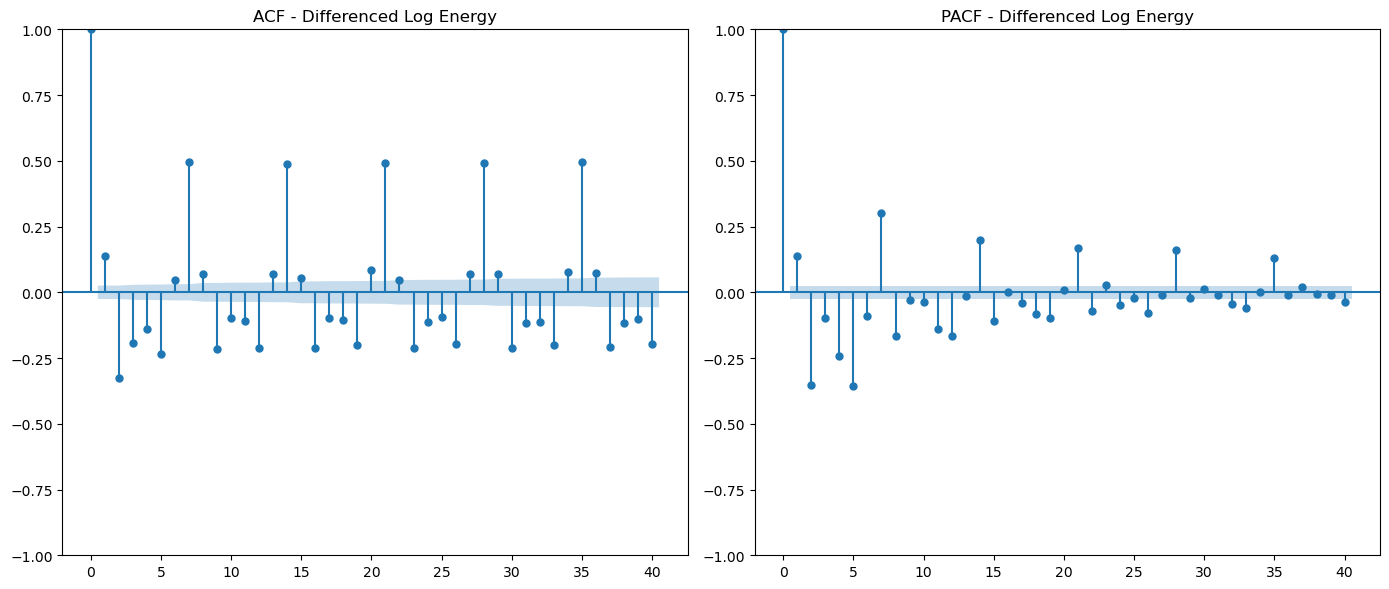

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Drop NaNs directly in the plot input
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(daily_avg['Diff_Log'].dropna(), lags=40, alpha=0.05, ax=plt.gca())
plt.title('ACF - Differenced Log Energy')

plt.subplot(1, 2, 2)
plot_pacf(daily_avg['Diff_Log'].dropna(), lags=40, alpha=0.05, method='ywm', ax=plt.gca())
plt.title('PACF - Differenced Log Energy')

plt.tight_layout()
plt.show()


In [53]:
data.columns

Index(['PJMW_MW', 'hour', 'Day', 'Month', 'Year', 'weekday', 'dayofweek',
       'is_holiday', 'Season', 'Hour'],
      dtype='object')

In [54]:
data_scaled = data.copy()
data_scaled['Day'] = data_scaled.index.day
data_scaled['dayofweek'] = data_scaled.index.dayofweek
data_scaled.head()

PJMW_MW  hour  Day  Month  Year  weekday  dayofweek  \
Datetime                                                                   
2002-12-31 01:00:00   5077.0     1   31     12  2002        1          1   
2002-12-31 02:00:00   4939.0     2   31     12  2002        1          1   
2002-12-31 03:00:00   4885.0     3   31     12  2002        1          1   
2002-12-31 04:00:00   4857.0     4   31     12  2002        1          1   
2002-12-31 05:00:00   4930.0     5   31     12  2002        1          1   

                     is_holiday  Season  Hour  
Datetime                                       
2002-12-31 01:00:00       False  Winter     1  
2002-12-31 02:00:00       False  Winter     2  
2002-12-31 03:00:00       False  Winter     3  
2002-12-31 04:00:00       False  Winter     4  
2002-12-31 05:00:00       False  Winter     5

### Applying Standard Scaler 

In [56]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['hour', 'Day', 'Month', 'Year', 'weekday', 'dayofweek']

data_scaled['Day'] = data_scaled.index.day
data_scaled['dayofweek'] = data_scaled.index.dayofweek

scaler = StandardScaler()
data_scaled[numerical_features] = scaler.fit_transform(data_scaled[numerical_features])

data_scaled[numerical_features].head()

hour       Day     Month      Year   weekday  \
Datetime                                                                
2002-12-31 01:00:00 -1.517188  1.735188  1.607582 -1.674026 -0.999401   
2002-12-31 02:00:00 -1.372716  1.735188  1.607582 -1.674026 -0.999401   
2002-12-31 03:00:00 -1.228245  1.735188  1.607582 -1.674026 -0.999401   
2002-12-31 04:00:00 -1.083773  1.735188  1.607582 -1.674026 -0.999401   
2002-12-31 05:00:00 -0.939301  1.735188  1.607582 -1.674026 -0.999401   

                     dayofweek  
Datetime                        
2002-12-31 01:00:00  -0.999401  
2002-12-31 02:00:00  -0.999401  
2002-12-31 03:00:00  -0.999401  
2002-12-31 04:00:00  -0.999401  
2002-12-31 05:00:00  -0.999401

### Applying One Hot Encoder

In [58]:
from sklearn.preprocessing import OneHotEncoder

# Copy the scaled data
data_encoded = data_scaled.copy()

# Binary encoding for 'is_holiday' (True/False to 1/0)
data_encoded['is_holiday'] = data_encoded['is_holiday'].astype(int)

# One-hot encode 'Season'
season_encoded = pd.get_dummies(data_encoded['Season'], prefix='Season', drop_first=True)

# Concatenate one-hot encoded columns and drop original
data_encoded = pd.concat([data_encoded.drop('Season', axis=1), season_encoded], axis=1)


In [59]:
data_encoded.head()

PJMW_MW      hour       Day     Month      Year  \
Datetime                                                               
2002-12-31 01:00:00   5077.0 -1.517188  1.735188  1.607582 -1.674026   
2002-12-31 02:00:00   4939.0 -1.372716  1.735188  1.607582 -1.674026   
2002-12-31 03:00:00   4885.0 -1.228245  1.735188  1.607582 -1.674026   
2002-12-31 04:00:00   4857.0 -1.083773  1.735188  1.607582 -1.674026   
2002-12-31 05:00:00   4930.0 -0.939301  1.735188  1.607582 -1.674026   

                      weekday  dayofweek  is_holiday  Hour  Season_Spring  \
Datetime                                                                    
2002-12-31 01:00:00 -0.999401  -0.999401           0     1          False   
2002-12-31 02:00:00 -0.999401  -0.999401           0     2          False   
2002-12-31 03:00:00 -0.999401  -0.999401           0     3          False   
2002-12-31 04:00:00 -0.999401  -0.999401           0     4          False   
2002-12-31 05:00:00 -0.999401  -0.999401           0     5          False   

                     Season_Summer  Season_Winter  
Datetime                                           
2002-12-31 01:00:00          False           True  
2002-12-31 02:00:00          False           True  
2002-12-31 03:00:00          False           True  
2002-12-31 04:00:00          False           True  
2002-12-31 05:00:00          False           True

### Train-Test Split 

In [61]:
# Ensure the index is datetime and sorted
data_encoded = data_encoded.sort_index()

# Define the split point: last 2 year of data for testing
split_date = data_encoded.index.max() - pd.DateOffset(years=2)

# Split the data
train = data_encoded[data_encoded.index < split_date]
test = data_encoded[data_encoded.index >= split_date]

# Confirm shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (125685, 12)
Test shape: (17521, 12)


In [62]:
# Features and target
X_train = train.drop(columns='PJMW_MW')
y_train = train['PJMW_MW']

X_test = test.drop(columns='PJMW_MW')
y_test = test['PJMW_MW']

In [63]:
y_train.head(5)

Datetime
2002-04-01 01:00:00    4374.0
2002-04-01 02:00:00    4306.0
2002-04-01 03:00:00    4322.0
2002-04-01 04:00:00    4359.0
2002-04-01 05:00:00    4436.0
Name: PJMW_MW, dtype: float64

## Model Building

#### 1.Moving Average (MA) Model

Last 48 in-sample predictions before forecast:
Datetime
2016-08-01 00:00:00    5629.916667
2016-08-01 01:00:00    5646.125000
2016-08-01 02:00:00    5658.750000
2016-08-01 03:00:00    5670.916667
2016-08-01 04:00:00    5684.916667
2016-08-01 05:00:00    5702.208333
2016-08-01 06:00:00    5727.666667
2016-08-01 07:00:00    5763.541667
2016-08-01 08:00:00    5805.083333
2016-08-01 09:00:00    5845.208333
2016-08-01 10:00:00    5885.875000
2016-08-01 11:00:00    5928.750000
2016-08-01 12:00:00    5973.583333
2016-08-01 13:00:00    6015.500000
2016-08-01 14:00:00    6054.000000
2016-08-01 15:00:00    6086.416667
2016-08-01 16:00:00    6114.416667
2016-08-01 17:00:00    6137.791667
2016-08-01 18:00:00    6156.958333
2016-08-01 19:00:00    6173.791667
2016-08-01 20:00:00    6190.666667
2016-08-01 21:00:00    6204.583333
2016-08-01 22:00:00    6219.916667
2016-08-01 23:00:00    6230.666667
2016-08-02 00:00:00    6238.083333
2016-08-02 01:00:00    6245.458333
2016-08-02 02:00:00    6254.041667

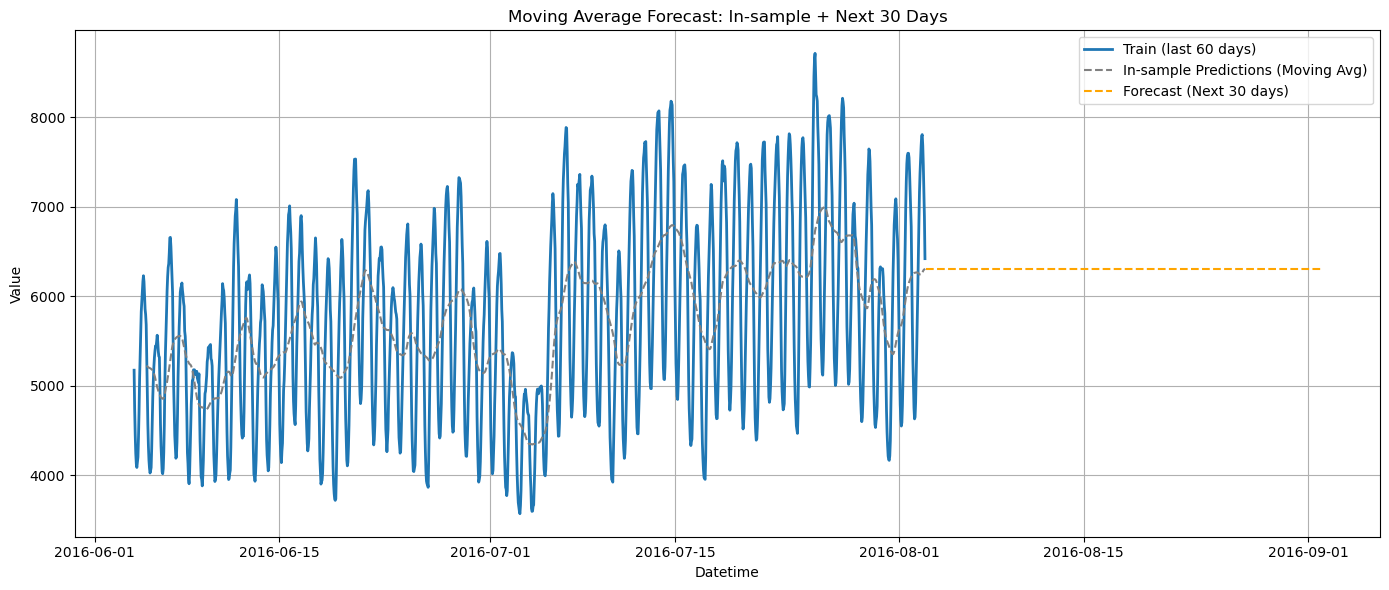

In [66]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# Ensure y_train and y_test are clean
y_train = y_train.squeeze().dropna()
y_test = y_test.squeeze().dropna()

# Use last 1440 hours (60 days) for training
y_train_ma = y_train[-1440:]

# Forecast horizon: 720 hours (30 days)
forecast_horizon = 720
window = 24  # 1-day moving average

# --- In-sample predictions (for training set) using moving average ---
in_sample_pred = y_train_ma.rolling(window=window).mean()

# Drop NaNs due to rolling window
in_sample_pred = in_sample_pred.dropna()

# Print last 48 in-sample predictions before forecast
print("Last 48 in-sample predictions before forecast:")
print(in_sample_pred[-48:])

# --- Forecast (constant value based on last 24-hour average) ---
last_avg = y_train_ma[-window:].mean()
forecast = pd.Series([last_avg] * forecast_horizon, index=y_test.index[:forecast_horizon])

# Metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)
mape = np.mean(np.abs((y_test[:forecast_horizon] - forecast) / y_test[:forecast_horizon])) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_train_ma.index, y_train_ma, label='Train (last 60 days)', linewidth=2)
plt.plot(in_sample_pred.index, in_sample_pred, label='In-sample Predictions (Moving Avg)', linestyle='--', color='gray')
plt.plot(forecast.index, forecast, label='Forecast (Next 30 days)', linestyle='--', color='orange')
plt.title('Moving Average Forecast: In-sample + Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Moving Average works on past errors, not past values. When the training period ends, there are no new errors. As a result, the forecast term becomes zero. 

#### 2.ARIMA MODEL

Last 48 in-sample predictions before forecast:
2016-08-01 00:00:00    5507.876464
2016-08-01 01:00:00    5110.040302
2016-08-01 02:00:00    4772.613517
2016-08-01 03:00:00    4527.179739
2016-08-01 04:00:00    4508.467269
2016-08-01 05:00:00    4543.443163
2016-08-01 06:00:00    4713.891509
2016-08-01 07:00:00    5035.429985
2016-08-01 08:00:00    5411.540839
2016-08-01 09:00:00    5692.593822
2016-08-01 10:00:00    6120.349035
2016-08-01 11:00:00    6520.498698
2016-08-01 12:00:00    6937.640697
2016-08-01 13:00:00    7313.302620
2016-08-01 14:00:00    7457.710759
2016-08-01 15:00:00    7562.070515
2016-08-01 16:00:00    7560.973780
2016-08-01 17:00:00    7504.466457
2016-08-01 18:00:00    7461.988312
2016-08-01 19:00:00    7373.638362
2016-08-01 20:00:00    7140.410370
2016-08-01 21:00:00    6874.470023
2016-08-01 22:00:00    6723.856899
2016-08-01 23:00:00    6523.402023
2016-08-02 00:00:00    5700.914743
2016-08-02 01:00:00    5239.981757
2016-08-02 02:00:00    4952.088350
2016-08-

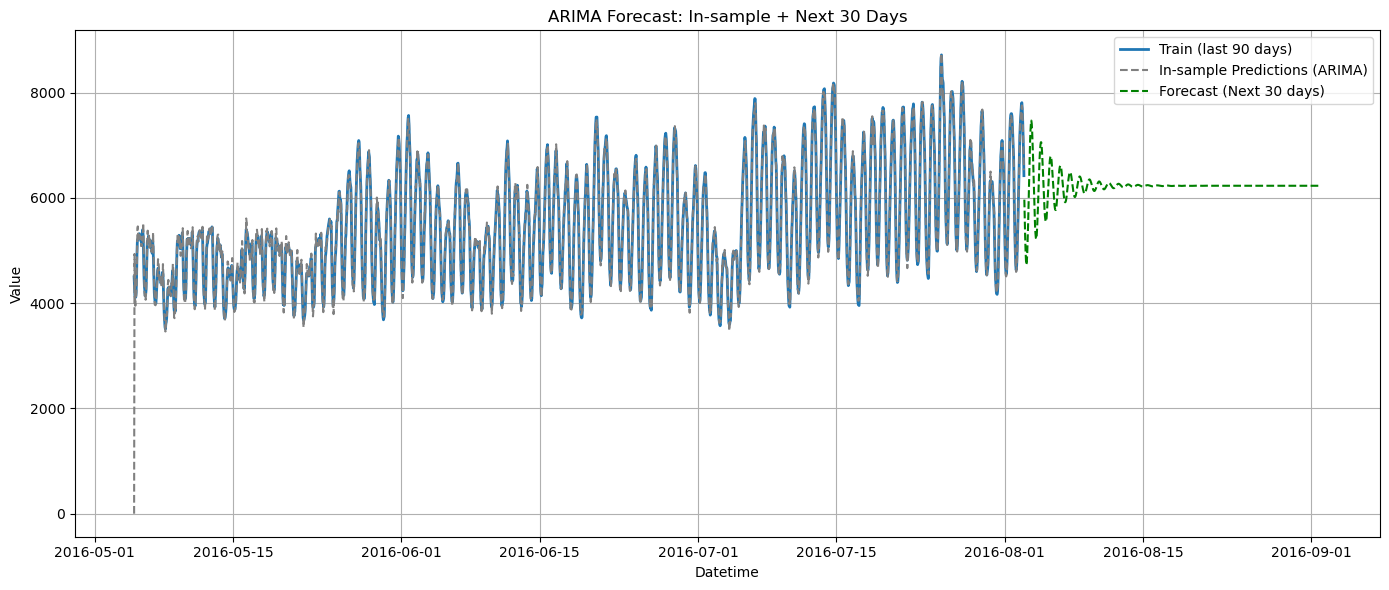

In [69]:
from statsmodels.tsa.arima.model import ARIMA

# Ensure data is clean
y_train = y_train.squeeze().dropna()
y_test = y_test.squeeze().dropna()

# Select last 2160 hours (90 days) for training
y_train_arima = y_train[-2160:]

# Forecast horizon: 720 hours (30 days)
forecast_horizon = 720

# Fit ARIMA model
model = ARIMA(y_train_arima, order=(5, 1, 3))  
model_fit = model.fit()

# --- In-sample prediction (for training window) ---
in_sample_pred = model_fit.predict(start=y_train_arima.index[0], end=y_train_arima.index[-1], typ='levels')

# Print last 48 in-sample predictions before forecast
print("Last 48 in-sample predictions before forecast:")
print(in_sample_pred[-48:])

# --- Forecast next 720 hours ---
forecast = model_fit.forecast(steps=forecast_horizon)
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)
mape = np.mean(np.abs((y_test[:720] - forecast) / y_test[:720])) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_train_arima.index, y_train_arima, label='Train (last 90 days)', linewidth=2)
plt.plot(in_sample_pred.index, in_sample_pred, label='In-sample Predictions (ARIMA)', linestyle='--', color='gray')
plt.plot(forecast.index, forecast, label='Forecast (Next 30 days)', linestyle='--', color='green')
plt.title('ARIMA Forecast: In-sample + Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.Auto ARIMA

##### Without Seasonality

In [72]:
!pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------- 625.1/625.1 kB 24.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 22.3 MB/s eta 0:00:00


Last 48 in-sample predictions before forecast:
Datetime
2016-08-01 00:00:00    5533.858676
2016-08-01 01:00:00    5142.382352
2016-08-01 02:00:00    4764.715375
2016-08-01 03:00:00    4509.867971
2016-08-01 04:00:00    4505.018638
2016-08-01 05:00:00    4532.781300
2016-08-01 06:00:00    4689.563085
2016-08-01 07:00:00    5007.935554
2016-08-01 08:00:00    5397.395326
2016-08-01 09:00:00    5704.602058
2016-08-01 10:00:00    6133.803694
2016-08-01 11:00:00    6513.304664
2016-08-01 12:00:00    6922.404407
2016-08-01 13:00:00    7312.903645
2016-08-01 14:00:00    7471.571061
2016-08-01 15:00:00    7577.333693
2016-08-01 16:00:00    7564.624292
2016-08-01 17:00:00    7503.936199
2016-08-01 18:00:00    7467.465117
2016-08-01 19:00:00    7373.707733
2016-08-01 20:00:00    7133.488094
2016-08-01 21:00:00    6868.522809
2016-08-01 22:00:00    6722.393566
2016-08-01 23:00:00    6529.640508
2016-08-02 00:00:00    5736.592662
2016-08-02 01:00:00    5283.603904
2016-08-02 02:00:00    4966.129712

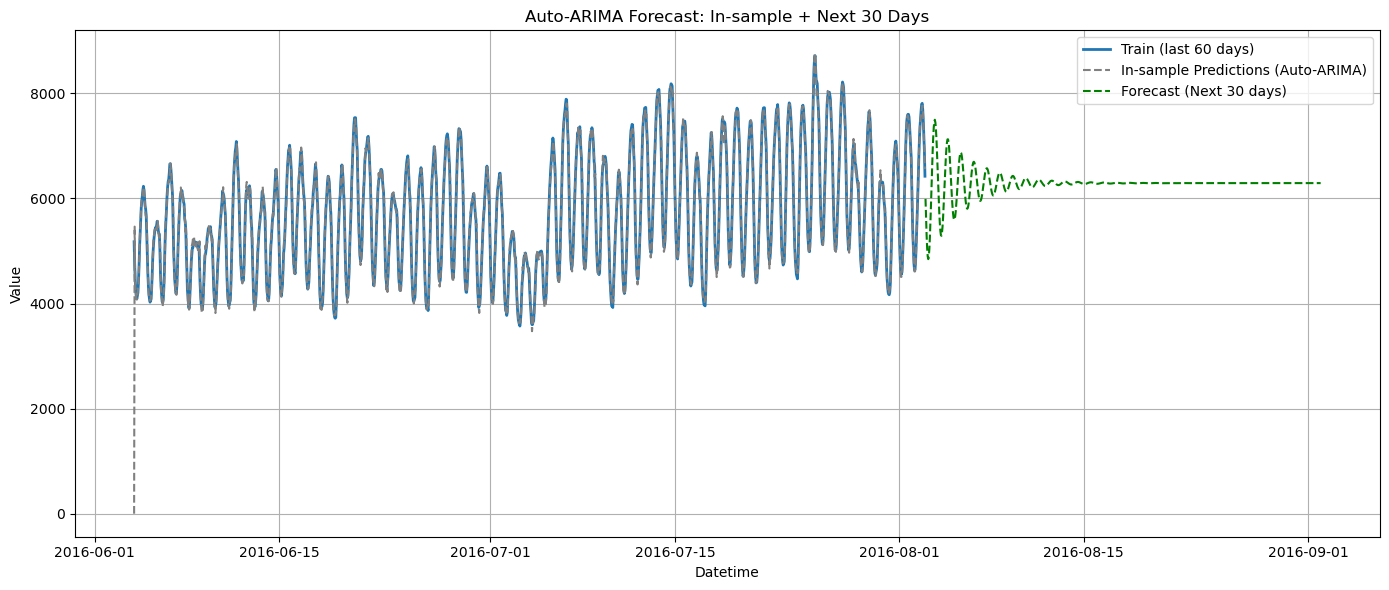

In [73]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data preprocessing
y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_train = pd.to_numeric(y_train, errors='coerce').ffill().bfill().dropna()
y_test = pd.to_numeric(y_test, errors='coerce').ffill().bfill().dropna()

y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# Use last 1440 hours for training
y_train_aarima = y_train[-1440:]

# Forecast horizon: 720 hours (30 days)
forecast_horizon = 720

# Fit auto-ARIMA model
model = auto_arima(
    y_train_aarima,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=False,
    start_p=1, start_q=1, max_p=5, max_q=5
)

# --- In-sample predictions ---
in_sample_pred = model.predict_in_sample()
in_sample_index = y_train_aarima.index
in_sample_series = pd.Series(in_sample_pred, index=in_sample_index)

# Print last 48 in-sample predictions before forecast
print("Last 48 in-sample predictions before forecast:")
print(in_sample_series[-48:])

# --- Forecast next 720 hours ---
forecast = model.predict(n_periods=forecast_horizon)
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)
mape = np.mean(np.abs((y_test[:720] - forecast) / y_test[:720])) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_train_aarima.index, y_train_aarima, label='Train (last 60 days)', linewidth=2)
plt.plot(in_sample_series.index, in_sample_series, label='In-sample Predictions (Auto-ARIMA)', linestyle='--', color='gray')
plt.plot(forecast.index, forecast, label='Forecast (Next 30 days)', linestyle='--', color='green')
plt.title('Auto-ARIMA Forecast: In-sample + Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### With Seasonality (Auto-SARIMA)

Last 48 in-sample predictions before forecast:
Datetime
2016-08-01 00:00:00    5527.142992
2016-08-01 01:00:00    5113.680395
2016-08-01 02:00:00    4810.759559
2016-08-01 03:00:00    4552.232661
2016-08-01 04:00:00    4504.318632
2016-08-01 05:00:00    4540.952088
2016-08-01 06:00:00    4658.638996
2016-08-01 07:00:00    4970.451361
2016-08-01 08:00:00    5403.553769
2016-08-01 09:00:00    5794.157463
2016-08-01 10:00:00    6104.504072
2016-08-01 11:00:00    6476.559397
2016-08-01 12:00:00    6915.628940
2016-08-01 13:00:00    7319.107829
2016-08-01 14:00:00    7476.913023
2016-08-01 15:00:00    7571.836477
2016-08-01 16:00:00    7561.402587
2016-08-01 17:00:00    7547.742960
2016-08-01 18:00:00    7523.587140
2016-08-01 19:00:00    7383.962549
2016-08-01 20:00:00    7146.419726
2016-08-01 21:00:00    6958.407365
2016-08-01 22:00:00    6688.608916
2016-08-01 23:00:00    6471.917298
2016-08-02 00:00:00    5746.146597
2016-08-02 01:00:00    5225.401021
2016-08-02 02:00:00    4927.159463

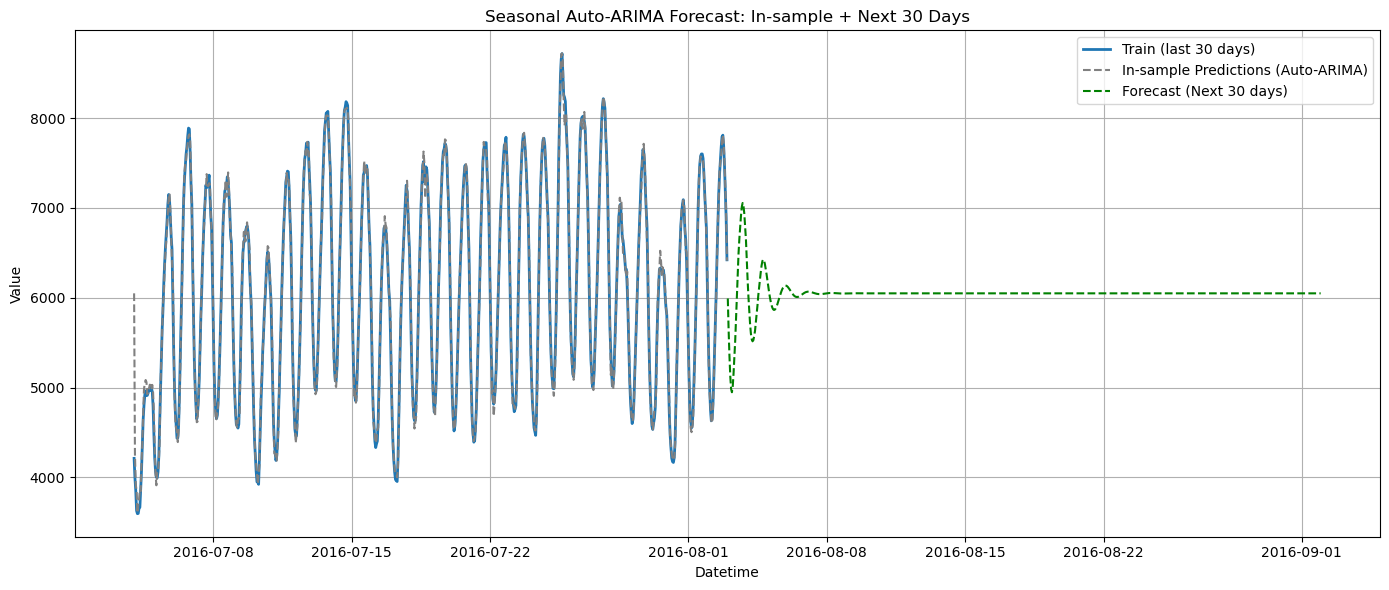

In [75]:
from pmdarima import auto_arima

# Clean and prepare data
y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_train = pd.to_numeric(y_train, errors='coerce').ffill().bfill().dropna()
y_test = pd.to_numeric(y_test, errors='coerce').ffill().bfill().dropna()

y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# Use last 720 hours for training (30 days)
y_train_aarima = y_train[-720:]

# Forecast horizon: 720 hours (30 days)
forecast_horizon = 720

# Fit seasonal auto-ARIMA
model = auto_arima(
    y_train_aarima,
    seasonal=True,
    m=24,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=False
)

# --- In-sample predictions ---
in_sample_pred = model.predict_in_sample()
in_sample_series = pd.Series(in_sample_pred, index=y_train_aarima.index)

# Print last 48 in-sample predictions before forecast
print("Last 48 in-sample predictions before forecast:")
print(in_sample_series[-48:])

# --- Forecast next 720 hours ---
forecast = model.predict(n_periods=forecast_horizon)
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Evaluate metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)
mape = np.mean(np.abs((y_test[:720] - forecast) / y_test[:720])) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(y_train_aarima.index, y_train_aarima, label='Train (last 30 days)', linewidth=2)
plt.plot(in_sample_series.index, in_sample_series, label='In-sample Predictions (Auto-ARIMA)', linestyle='--', color='gray')
plt.plot(forecast.index, forecast, label='Forecast (Next 30 days)', linestyle='--', color='green')
plt.title('Seasonal Auto-ARIMA Forecast: In-sample + Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MAE: 965.55
RMSE: 1131.70
MAPE: 15.72%


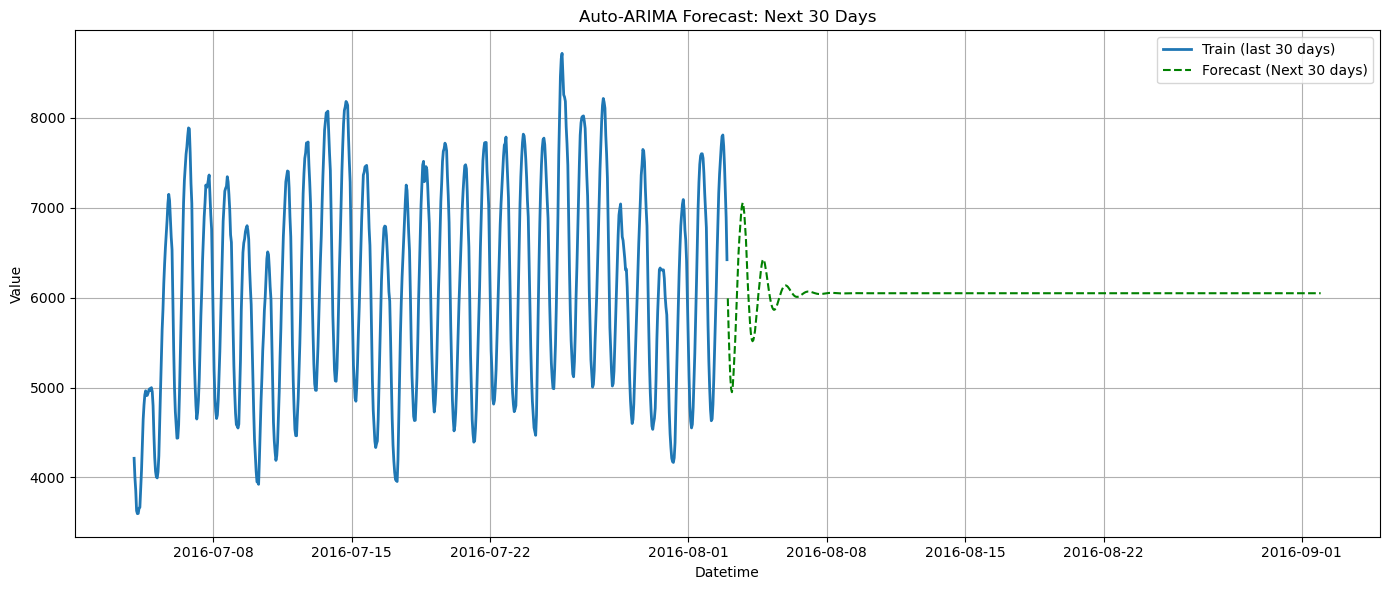

In [76]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Setting training and testing data
y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

y_train = y_train.ffill().bfill()
y_test = y_test.ffill().bfill()

y_train = y_train.dropna()
y_test = y_test.dropna()

y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# Use last 720 hours for training
y_train_aarima = y_train[-720:]

# Forecast horizon: 30 days = 720 hours
forecast_horizon = 720

# Fit auto-ARIMA model
model = auto_arima(
    y_train_aarima,
    seasonal=True,       # Seasonality is enabled
    m=24,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',  
    trace=False          
)

# Forecast next 720 hours
forecast = model.predict(n_periods=forecast_horizon)

# Create forecast index matching test
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
mape = np.mean(np.abs((y_test[:720] - forecast) / y_test[:720])) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_train_aarima.index, y_train_aarima, label='Train (last 30 days)', linewidth=2)
#plt.plot(y_test[:forecast_horizon].index, y_test[:forecast_horizon], label='Actual (30 days)', color='blue')
plt.plot(forecast.index, forecast, label='Forecast (Next 30 days)', linestyle='--', color='green')
plt.title('Auto-ARIMA Forecast: Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.SARIMA MODEL

##### Finding the best parameters using Auto-ARIMA with Seasonality

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=8568.539, Time=4.94 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=12215.908, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.24 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=14621.663, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=8537.310, Time=2.72 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=8705.389, Time=0.73 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=8481.481, Time=10.24 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=8494.736, Time=13.24 sec
 ARIMA(1,0,2)(0,0,2)[24] intercept   : AIC=8803.222, Time=9.93 sec
 ARIMA(2,0,1)(0,0,2)[24] intercept   : AIC=8485.613, Time=8.32 sec
 ARIMA(3,0,2)(0,0,2)[24] intercept   : AIC=8483.825, Time=13.12 sec
 ARIMA(2,0,3)(0,0,2)[24] intercept   : AIC=8480.669, Time=12.03 sec
 ARIMA(2,0,3)(0,0,1)[24] intercept   : AIC=8531.737, Time=2.18 sec
 ARIMA(2,0,3)(1,0,2)[24

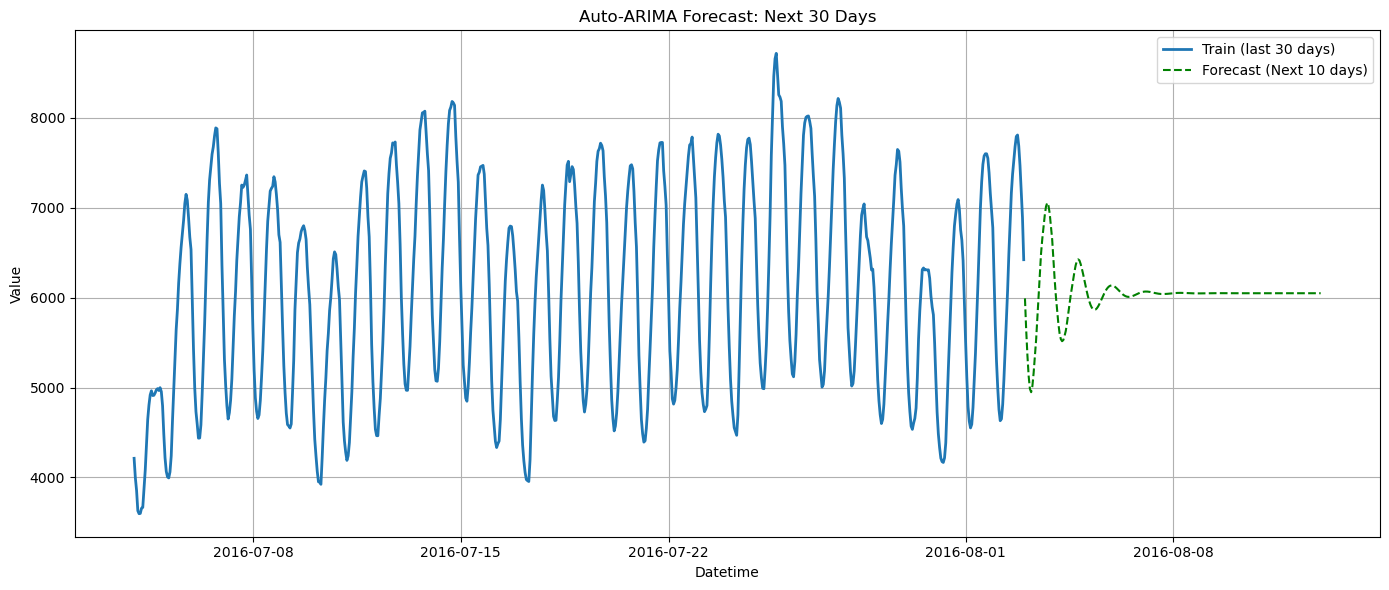

In [79]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Setting training and testing data
y_train = y_train.squeeze()
y_test = y_test.squeeze()

y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

y_train = y_train.ffill().bfill()
y_test = y_test.ffill().bfill()

y_train = y_train.dropna()
y_test = y_test.dropna()

y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# Use last 720 hours for training
y_train_aarima = y_train[-720:]

# Forecast horizon: 10 days = 240 hours
forecast_horizon = 240

# Fit auto-ARIMA model
model = auto_arima(
    y_train_aarima,
    seasonal=True,       # Seasonality is enabled
    m=24,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',  
    trace=True          
)

# Forecast next 720 hours
forecast = model.predict(n_periods=forecast_horizon)

# Create forecast index matching test
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
mape = np.mean(np.abs((y_test[:720] - forecast) / y_test[:720])) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_train_aarima.index, y_train_aarima, label='Train (last 30 days)', linewidth=2)
#plt.plot(y_test[:forecast_horizon].index, y_test[:forecast_horizon], label='Actual (30 days)', color='blue')
plt.plot(forecast.index, forecast, label='Forecast (Next 10 days)', linestyle='--', color='green')
plt.title('Auto-ARIMA Forecast: Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Building the SARIMAX Model

Last 48 in-sample predictions before forecast:
Datetime
2016-08-01 00:00:00    5532.996757
2016-08-01 01:00:00    5121.857955
2016-08-01 02:00:00    4814.797504
2016-08-01 03:00:00    4561.678160
2016-08-01 04:00:00    4513.765802
2016-08-01 05:00:00    4552.891042
2016-08-01 06:00:00    4672.994289
2016-08-01 07:00:00    4980.456461
2016-08-01 08:00:00    5411.079810
2016-08-01 09:00:00    5803.916406
2016-08-01 10:00:00    6119.611466
2016-08-01 11:00:00    6481.439948
2016-08-01 12:00:00    6913.416141
2016-08-01 13:00:00    7313.634156
2016-08-01 14:00:00    7467.949807
2016-08-01 15:00:00    7563.997696
2016-08-01 16:00:00    7554.743954
2016-08-01 17:00:00    7533.358262
2016-08-01 18:00:00    7508.602953
2016-08-01 19:00:00    7369.740469
2016-08-01 20:00:00    7133.378526
2016-08-01 21:00:00    6943.923129
2016-08-01 22:00:00    6681.431882
2016-08-01 23:00:00    6462.953705
2016-08-02 00:00:00    5746.554186
2016-08-02 01:00:00    5228.044575
2016-08-02 02:00:00    4931.816615

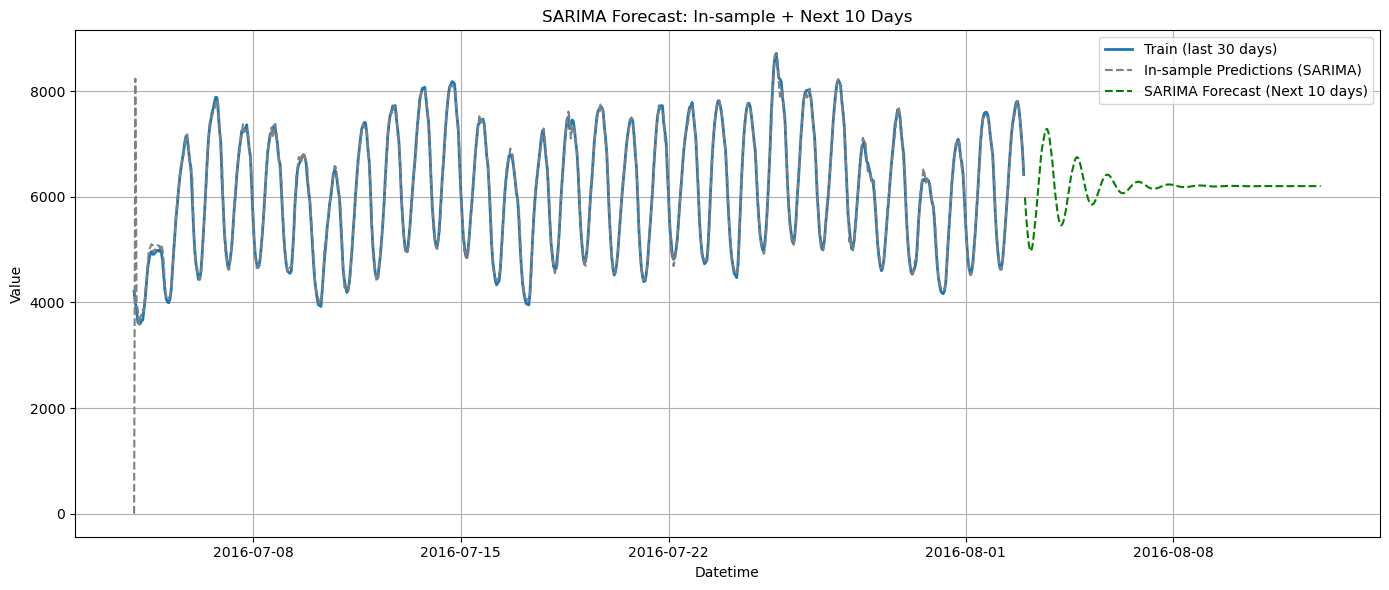

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Clean data
y_train = y_train.squeeze().ffill().bfill()
y_test = y_test.squeeze().ffill().bfill()
y_train = pd.to_numeric(y_train, errors='coerce').dropna()
y_test = pd.to_numeric(y_test, errors='coerce').dropna()
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# Use last 720 hours for training
y_train_sarima = y_train[-720:]
forecast_horizon = 240  # 10 days

# Fit SARIMA model
model = SARIMAX(
    y_train_sarima,
    order=(2, 0, 3),
    seasonal_order=(0, 0, 2, 24),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# --- In-sample predictions ---
in_sample_pred = model.fittedvalues

# Print last 48 in-sample predictions before forecast
print("Last 48 in-sample predictions before forecast:")
print(in_sample_pred[-48:])

# --- Forecast next 240 hours ---
forecast = model.forecast(steps=forecast_horizon)
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Evaluate
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)
mape = np.mean(np.abs((y_test[:forecast_horizon] - forecast) / y_test[:forecast_horizon])) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(y_train_sarima.index, y_train_sarima, label='Train (last 30 days)', linewidth=2)
plt.plot(in_sample_pred.index, in_sample_pred, label='In-sample Predictions (SARIMA)', linestyle='--', color='gray')
plt.plot(forecast.index, forecast, label='SARIMA Forecast (Next 10 days)', linestyle='--', color='green')
plt.title('SARIMA Forecast: In-sample + Next 10 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5.Holt Winter's Model

Last 48 in-sample predictions before forecast:
Datetime
2016-08-01 00:00:00    5454.911676
2016-08-01 01:00:00    5098.396253
2016-08-01 02:00:00    4823.721536
2016-08-01 03:00:00    4595.161083
2016-08-01 04:00:00    4510.850103
2016-08-01 05:00:00    4550.315413
2016-08-01 06:00:00    4714.915145
2016-08-01 07:00:00    4978.682750
2016-08-01 08:00:00    5401.861430
2016-08-01 09:00:00    5753.491842
2016-08-01 10:00:00    6145.414132
2016-08-01 11:00:00    6539.629950
2016-08-01 12:00:00    6926.419378
2016-08-01 13:00:00    7275.381837
2016-08-01 14:00:00    7488.537442
2016-08-01 15:00:00    7618.847930
2016-08-01 16:00:00    7630.576319
2016-08-01 17:00:00    7661.956414
2016-08-01 18:00:00    7597.544361
2016-08-01 19:00:00    7484.829456
2016-08-01 20:00:00    7151.773998
2016-08-01 21:00:00    6932.746556
2016-08-01 22:00:00    6770.165475
2016-08-01 23:00:00    6281.423019
2016-08-02 00:00:00    5691.731317
2016-08-02 01:00:00    5262.785124
2016-08-02 02:00:00    4990.319301

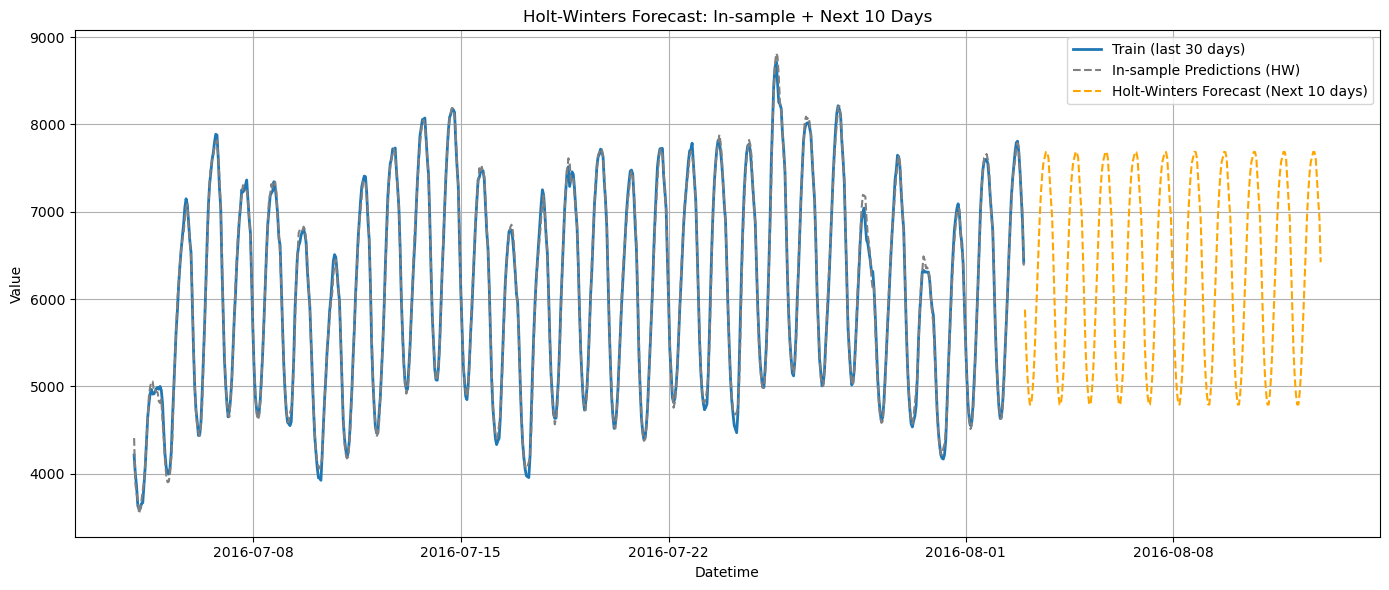

In [83]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Preprocessing
y_train = y_train.squeeze().ffill().bfill()
y_test = y_test.squeeze().ffill().bfill()
y_train = pd.to_numeric(y_train, errors='coerce').dropna()
y_test = pd.to_numeric(y_test, errors='coerce').dropna()
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)

# Use last 30 days (720 hours) for training
y_train_hw = y_train[-720:]
forecast_horizon = 240  # 10 days

# Fit Holt-Winters model
model = ExponentialSmoothing(
    y_train_hw,
    seasonal='mul',
    seasonal_periods=24
).fit()

# Get fitted values on training data
in_sample_pred = model.fittedvalues

# Print last 48 in-sample predictions
print("Last 48 in-sample predictions before forecast:")
print(in_sample_pred[-48:])

# Forecast
forecast = model.forecast(forecast_horizon)
forecast_index = y_test.index[:forecast_horizon]
forecast = pd.Series(forecast, index=forecast_index)

# Evaluation metrics
mae = mean_absolute_error(y_test[:forecast_horizon], forecast)
rmse = mean_squared_error(y_test[:forecast_horizon], forecast, squared=False)
mape = np.mean(np.abs((y_test[:forecast_horizon] - forecast) / y_test[:forecast_horizon])) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_train_hw.index, y_train_hw, label='Train (last 30 days)', linewidth=2)
plt.plot(in_sample_pred.index, in_sample_pred, label='In-sample Predictions (HW)', linestyle='--', color='gray')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast (Next 10 days)', linestyle='--', color='orange')
plt.title('Holt-Winters Forecast: In-sample + Next 10 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6.Prophet Model

In [85]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --------- ------------------------------ 3.1/13.3 MB 23.1 MB/s eta 0:00:01
   ------------------- -------------------- 6.6/13.3 MB 16.1 MB/s eta 0:00:01
   ------------------------ --------------- 8.1/13.3 MB 13.2 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 14.5 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 13.5 MB/s eta 0:00:00


18:40:38 - cmdstanpy - INFO - Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing


Last 48 in-sample predictions before 30-day forecast (Prophet):
ds
2016-08-01 00:00:00    5479.358731
2016-08-01 01:00:00    5084.566868
2016-08-01 02:00:00    4782.133402
2016-08-01 03:00:00    4600.329455
2016-08-01 04:00:00    4535.101999
2016-08-01 05:00:00    4570.686544
2016-08-01 06:00:00    4697.981682
2016-08-01 07:00:00    4918.672681
2016-08-01 08:00:00    5233.016404
2016-08-01 09:00:00    5621.597043
2016-08-01 10:00:00    6038.416048
2016-08-01 11:00:00    6427.317136
2016-08-01 12:00:00    6752.467301
2016-08-01 13:00:00    7013.494265
2016-08-01 14:00:00    7228.730979
2016-08-01 15:00:00    7405.876897
2016-08-01 16:00:00    7531.664893
2016-08-01 17:00:00    7588.521400
2016-08-01 18:00:00    7575.353051
2016-08-01 19:00:00    7504.835400
2016-08-01 20:00:00    7378.674053
2016-08-01 21:00:00    7171.808138
2016-08-01 22:00:00    6851.298745
2016-08-01 23:00:00    6418.533235
2016-08-02 00:00:00    5930.783538
2016-08-02 01:00:00    5475.398411
2016-08-02 02:00:00    

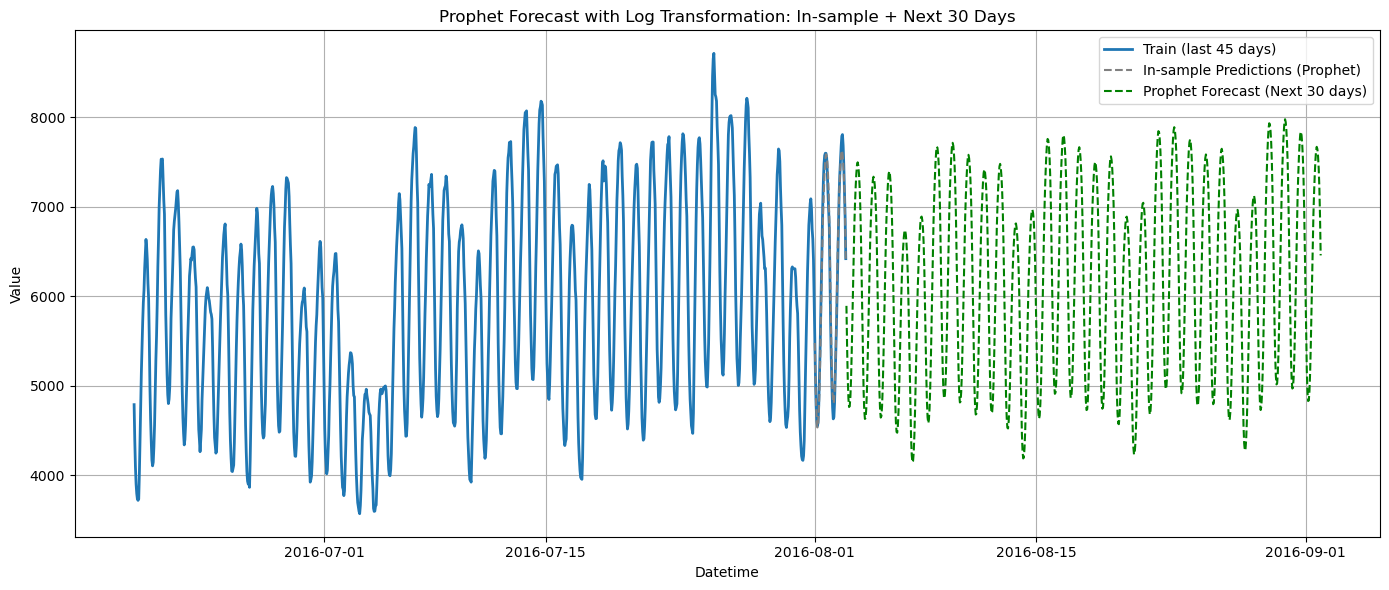

In [86]:
from prophet import Prophet

# Use last 45 days (1080 hours) for training
y_train_prophet = y_train[-1080:]
forecast_horizon = 720  # Forecast next 30 days

# Prepare data for Prophet
df_train = y_train_prophet.reset_index()
df_train.columns = ['ds', 'y']
df_train['y'] = np.log1p(df_train['y'])  # log transform

# Fit model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    n_changepoints=90,
    changepoint_prior_scale=0.1,
    changepoint_range=0.90,
    seasonality_mode='multiplicative'
)
model.fit(df_train)

# Create future dataframe
future = model.make_future_dataframe(periods=forecast_horizon, freq='H')

# Predict
forecast = model.predict(future)

# Reverse transformation for full forecast (in-sample + out-of-sample)
full_forecast = forecast[['ds', 'yhat']].set_index('ds')
full_forecast = np.expm1(full_forecast['yhat'])

# Separate in-sample predictions (before forecast horizon)
in_sample_pred = full_forecast[:-forecast_horizon]
in_sample_pred = in_sample_pred[-48:]  # Show last 48 hours

# Print last 48 in-sample predictions
print("Last 48 in-sample predictions before 30-day forecast (Prophet):")
print(in_sample_pred)

# Get only the forecast part
forecast_series = full_forecast[-forecast_horizon:]
forecast_series.index.freq = 'H'

# Evaluation
y_test_eval = y_test[:forecast_horizon]
mae = mean_absolute_error(y_test_eval, forecast_series)
rmse = mean_squared_error(y_test_eval, forecast_series, squared=False)
mape = np.mean(np.abs((y_test_eval - forecast_series) / y_test_eval)) * 100

print(f"\nMAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_train_prophet.index, y_train_prophet, label='Train (last 45 days)', linewidth=2)
plt.plot(in_sample_pred.index, in_sample_pred, label='In-sample Predictions (Prophet)', linestyle='--', color='gray')
plt.plot(forecast_series.index, forecast_series, label='Prophet Forecast (Next 30 days)', linestyle='--', color='green')
plt.title('Prophet Forecast with Log Transformation: In-sample + Next 30 Days')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparison of Model Performances

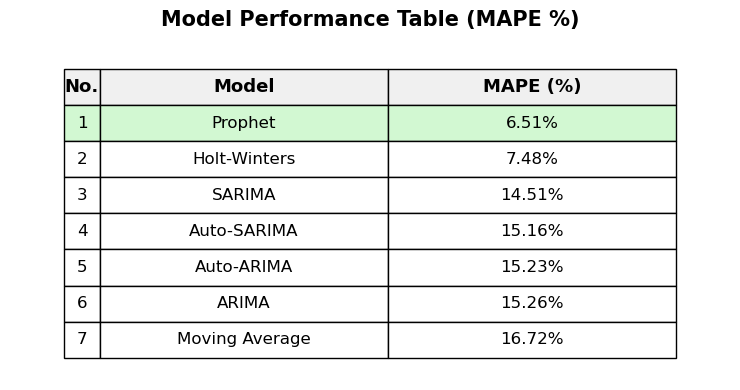

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# MAPE results
data = {
    'Model': [
        'Prophet', 'Holt-Winters', 'SARIMA',
        'Auto-SARIMA', 'Auto-ARIMA', 'ARIMA', 'Moving Average'
    ],
    'MAPE (%)': [6.51, 7.48, 14.51, 15.16, 15.23, 15.26, 16.72]
}

# Create and format DataFrame
df = pd.DataFrame(data)
df = df.sort_values(by='MAPE (%)').reset_index(drop=True)
df['MAPE (%)'] = df['MAPE (%)'].apply(lambda x: f"{x:.2f}%")
df.index = [f"{i+1}" for i in df.index]
df.insert(0, 'No.', df.index)

# Plot the table
fig, ax = plt.subplots(figsize=(7.5, 4))
ax.axis('off')

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    colLoc='center',
    loc='center'
)

# Style table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2.0)  # Wider and taller rows

# Format cells
for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('black')

    # Header row
    if row == 0:
        cell.set_text_props(weight='bold', fontsize=13)
        cell.set_facecolor('#f0f0f0')
    # Highlight Prophet row
    elif df.iloc[row - 1, 1] == 'Prophet':
        cell.set_facecolor('#d2f8d2')
    else:
        cell.set_facecolor('#ffffff')

    # Narrow "No." column (first column)
    if col == 0:
        cell.set_width(0.05)

# Add title
plt.title("Model Performance Table (MAPE %)", fontsize=15, weight='bold', pad=15)

plt.tight_layout()
plt.show()

#### On Comparing the performance of the Timeseries models built, Prophet model is found to have performed better than the others with a Mean Absolute Percentage Error (MAPE) of 6.51%. Therefore, we have decided to choose this model as the final one.

In [146]:
import joblib

joblib.dump(model, 'prophet_model.pkl')

['prophet_model.pkl']